In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

# Intrinsic Bias

In [4]:
results = pd.DataFrame(columns=['data','model','metric','bias_type','bias_score'])

datasets = ['cp', 'ss']
models = ['albert-base-v2', 'roberta-large', 'bert-base-cased', 'bert-base-uncased', 'bert-large-cased', 'bert-large-uncased']
metrics = ['sss', 'cps', 'aula']
bias_type = {
    'cp': ['race-color', 'socioeconomic', 'gender', 'disability',
       'nationality', 'sexual-orientation', 'physical-appearance',
       'religion', 'age', 'all'],
    'ss': ['profession', 'race', 'gender', 'religion', 'all'],
    
}

for data in datasets:
    for m in models:
        for met in metrics:
            ds = pd.read_csv(f'results/{m}/{met}_{data}.csv')
            for b in bias_type[data]:
                new_row = {
                    'data': data,
                    'model': m,
                    'metric': met,
                    'bias_type': b,
                    'bias_score': (100/len(ds[ds['bias_type']==b]['st>at']))*(ds[ds['bias_type']==b]['st>at'].sum())-50 if b!='all' else (100/len(ds['st>at']))*ds['st>at'].sum()-50
                    # 'bias_score': ds[ds['bias_type']==b]['st>at'].mean() if b!='all' else ds['st>at'].mean()
                }

                results = pd.concat([results, pd.DataFrame(new_row, index=[0])], ignore_index=True)


### Insights from Intrinsic Biases
Positive values: bias towar stereotypical group.

According to the results, the models tend to be biased toward the stereotypical groups along the three metrics in the two datasets under evaluation.

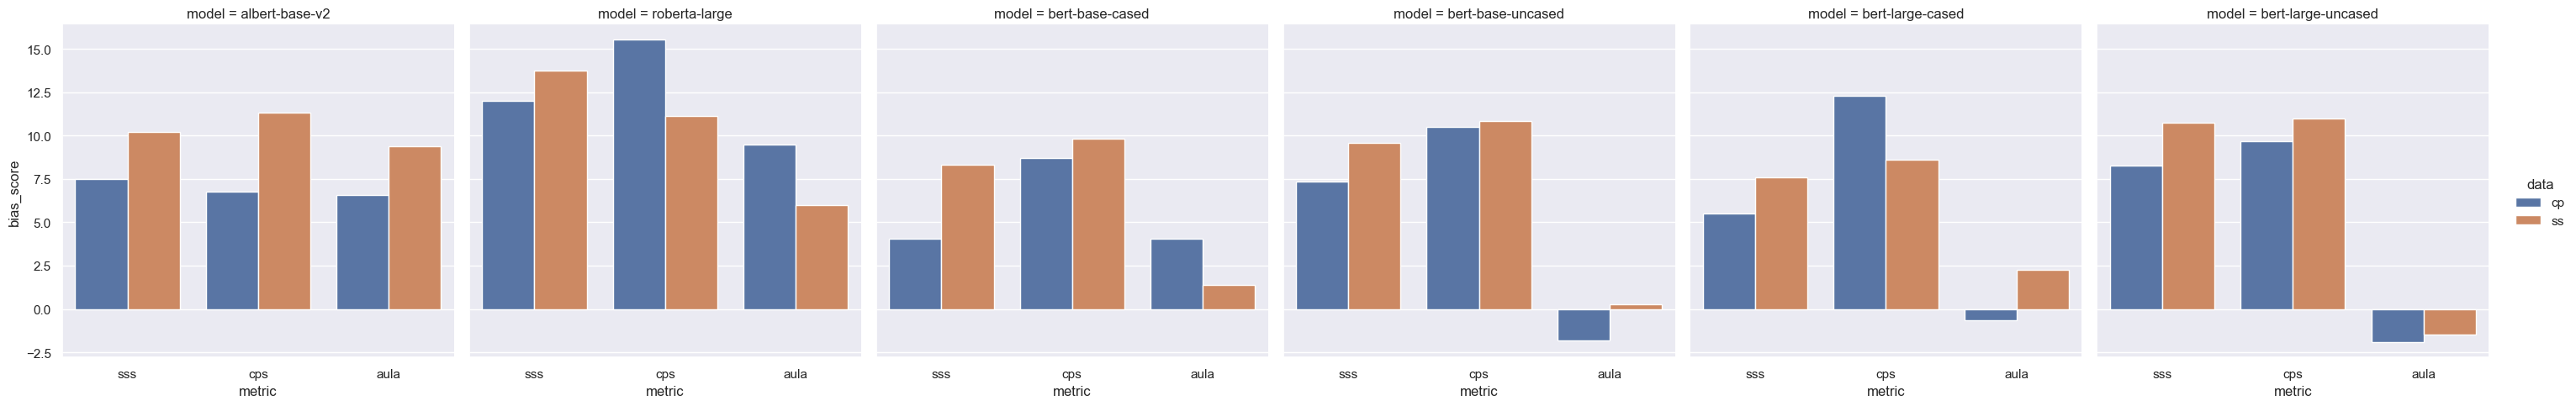

In [5]:
sns.catplot(data=results[results['bias_type']=='all'],kind='bar',x='metric',y='bias_score', hue='data', col='model')

When observing biases by group sensitive attributes, we come up with the following insights:

#### Dataset: CP

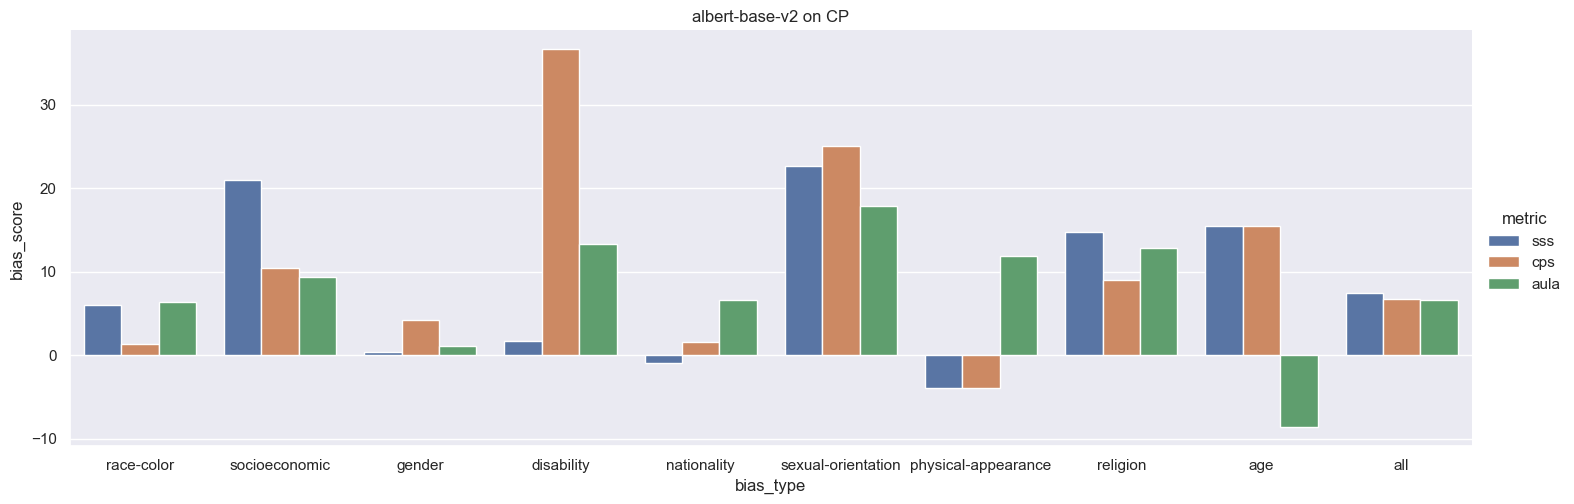

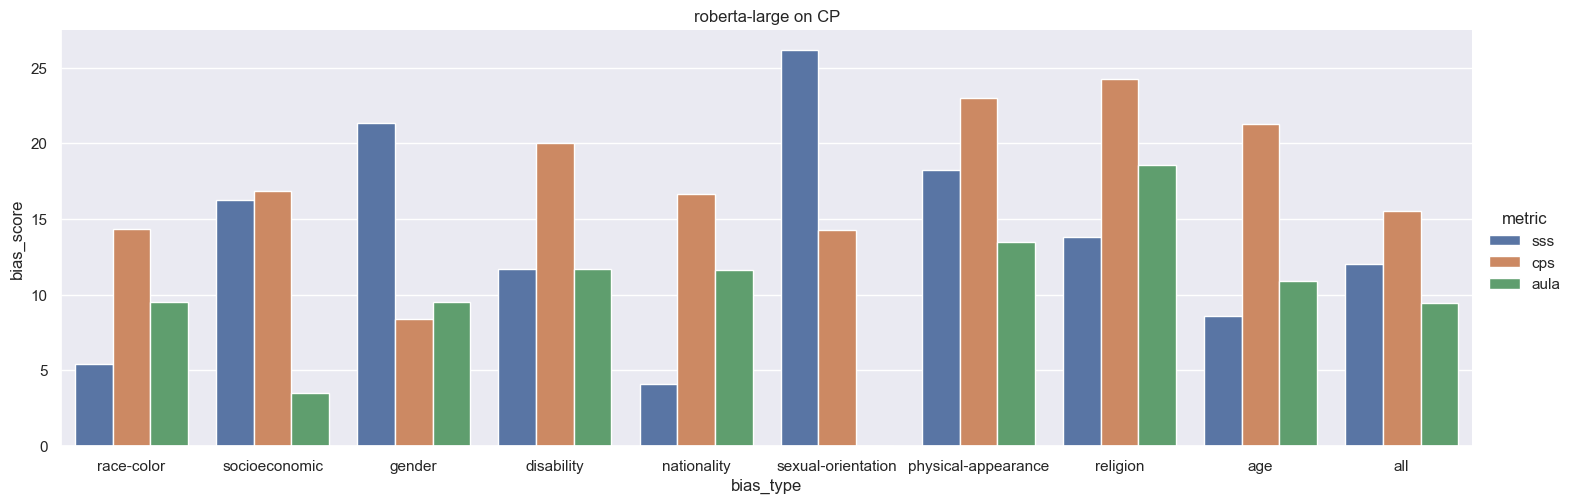

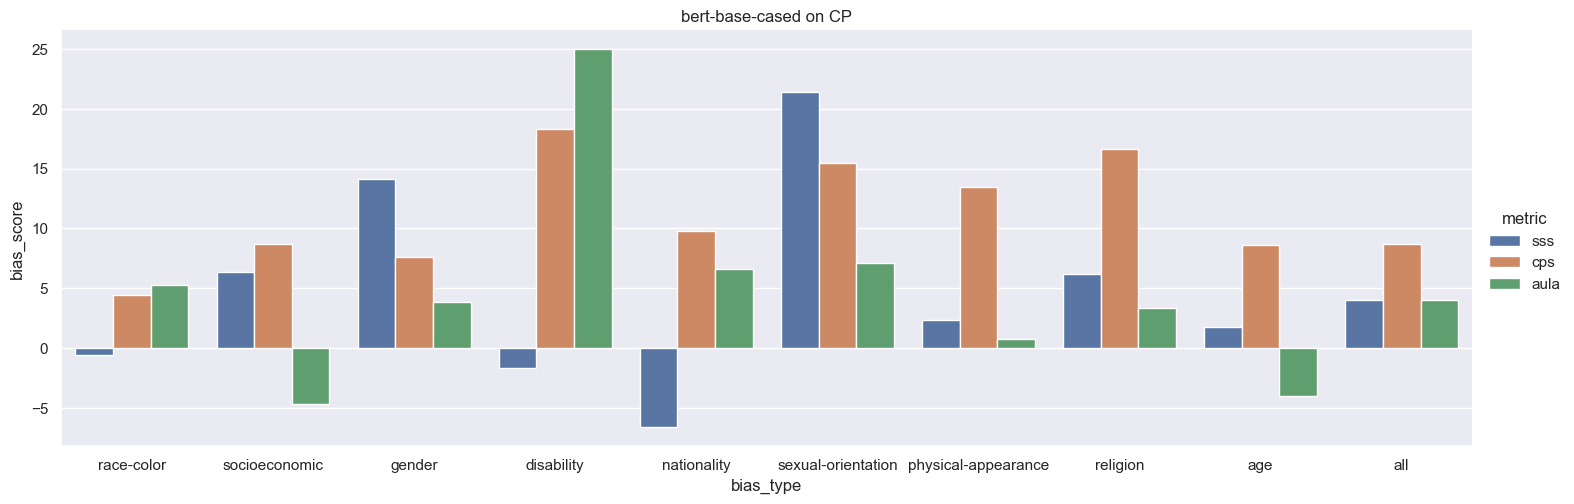

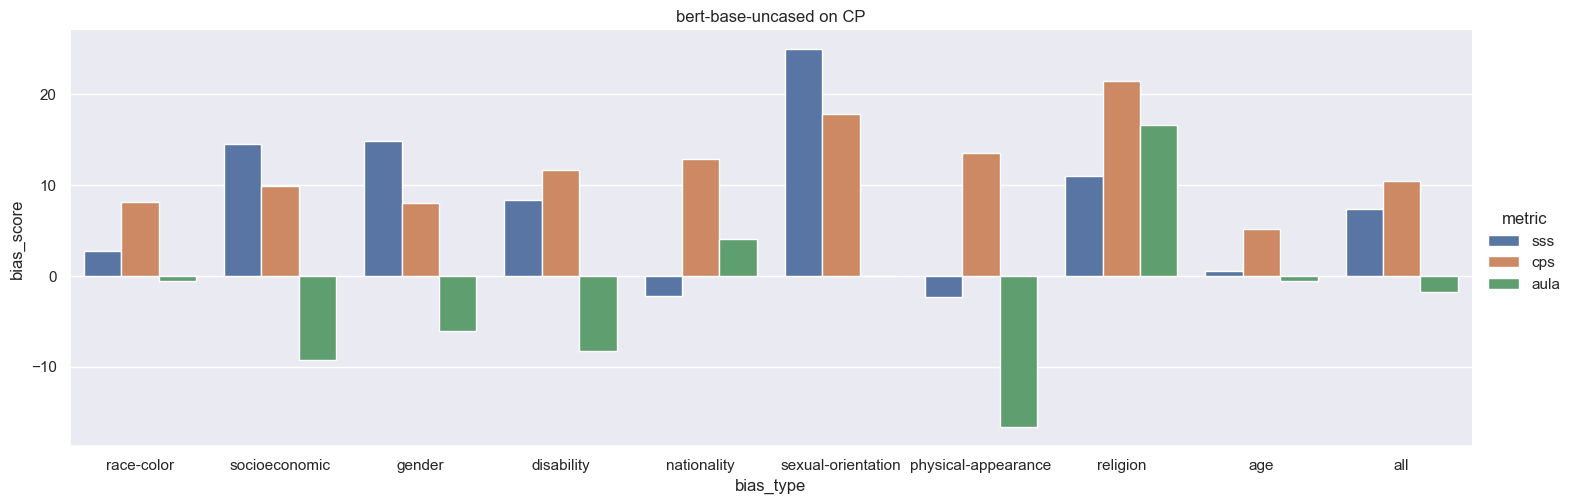

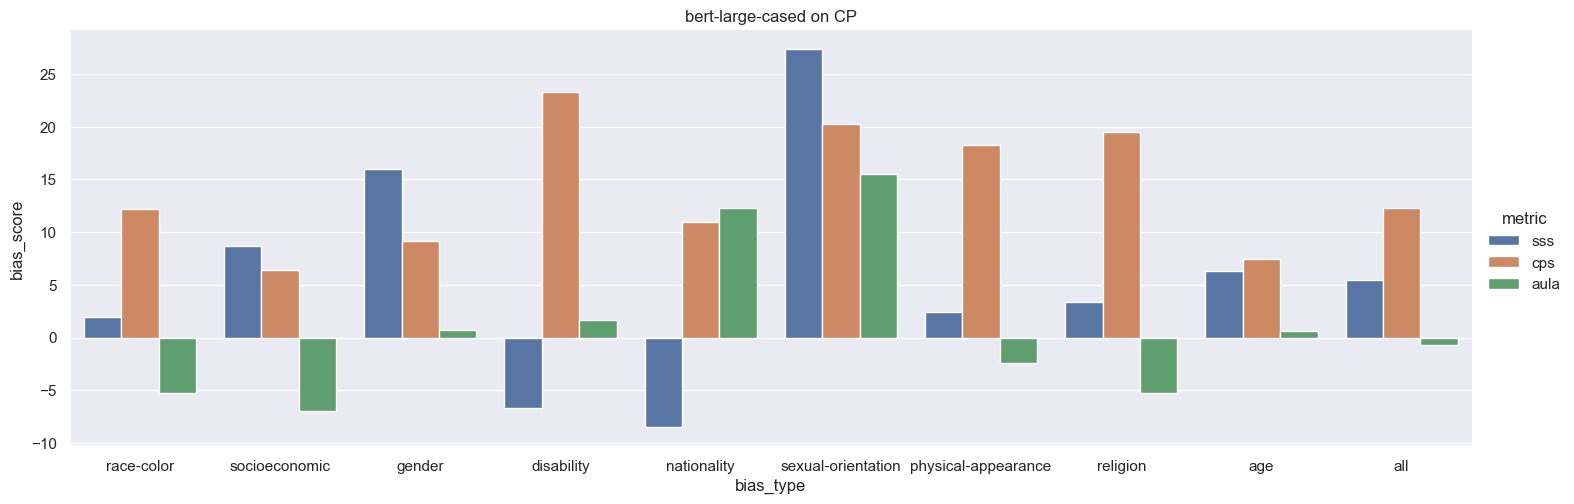

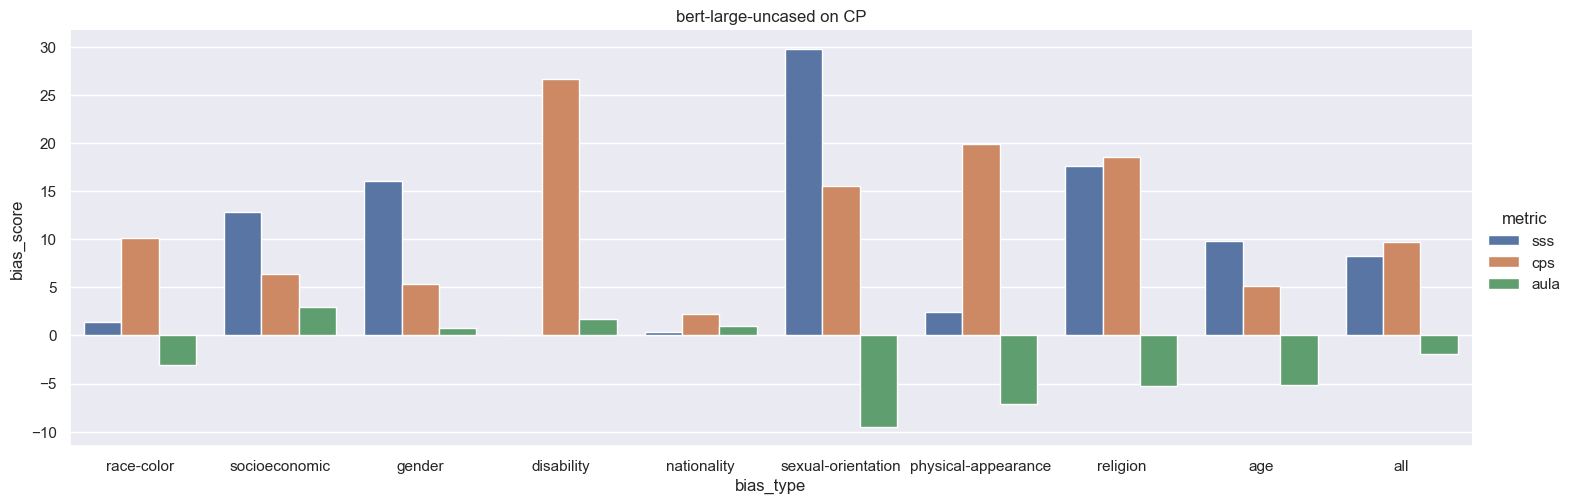

In [7]:
for m in models:
    sns.catplot(data=results[(results['data']=='cp') & (results['model']==m)],x='bias_type',y='bias_score', hue='metric', kind='bar', aspect=3.)
    plt.title(f'{m} on CP')
    plt.show()

#### Datasets: SS

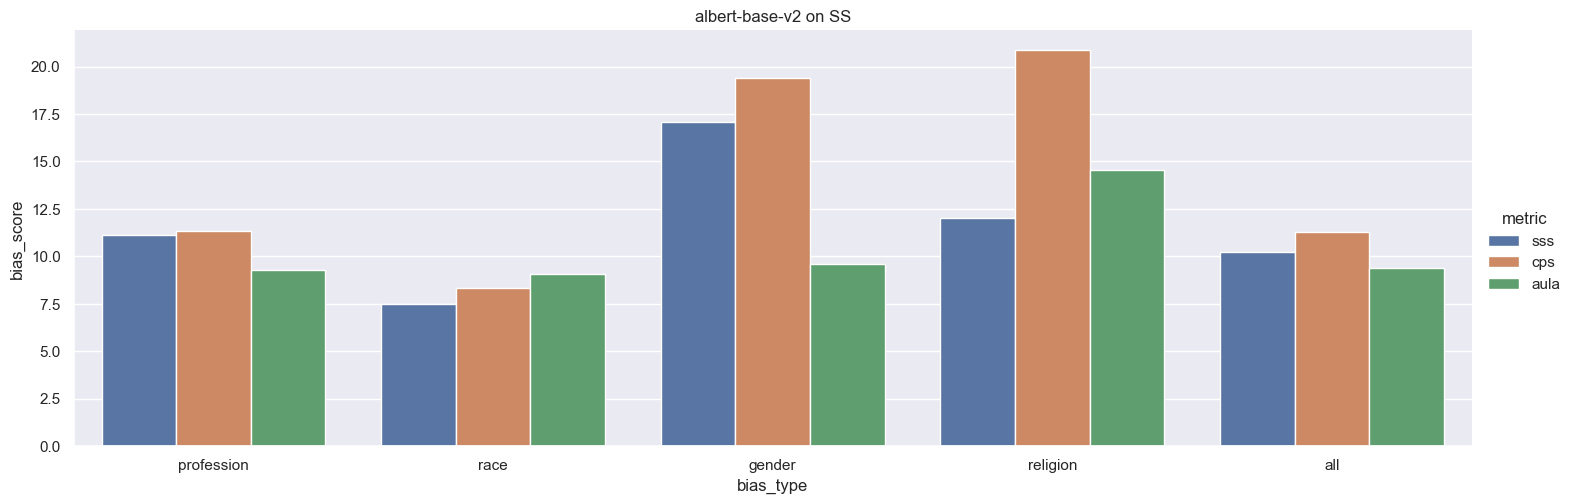

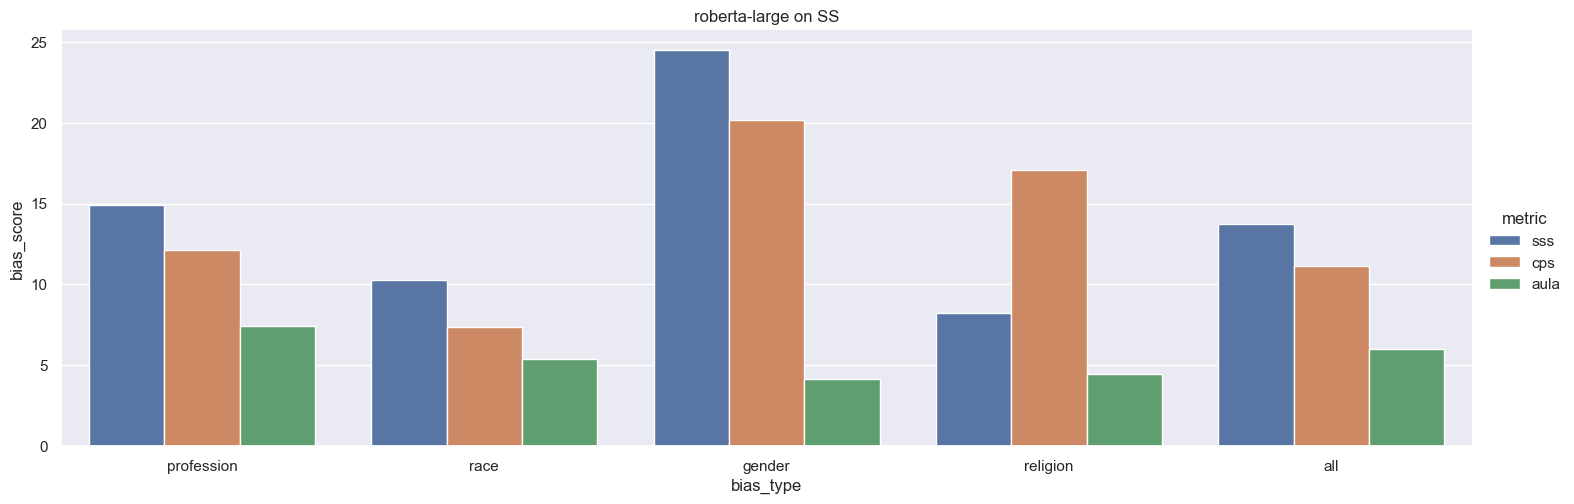

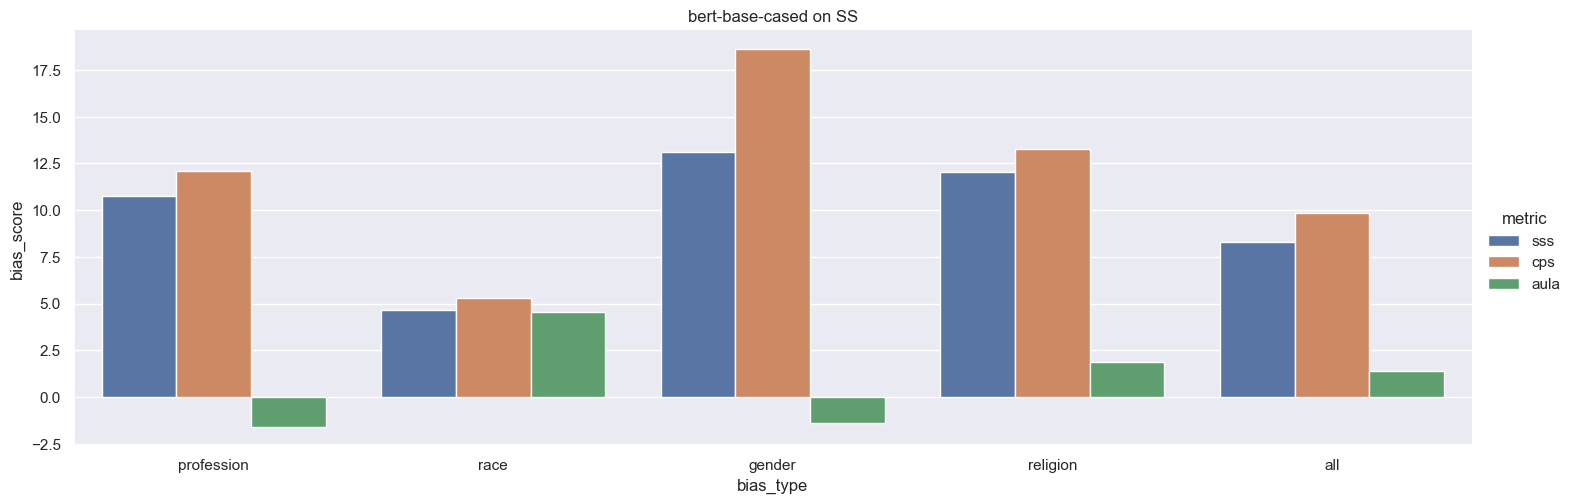

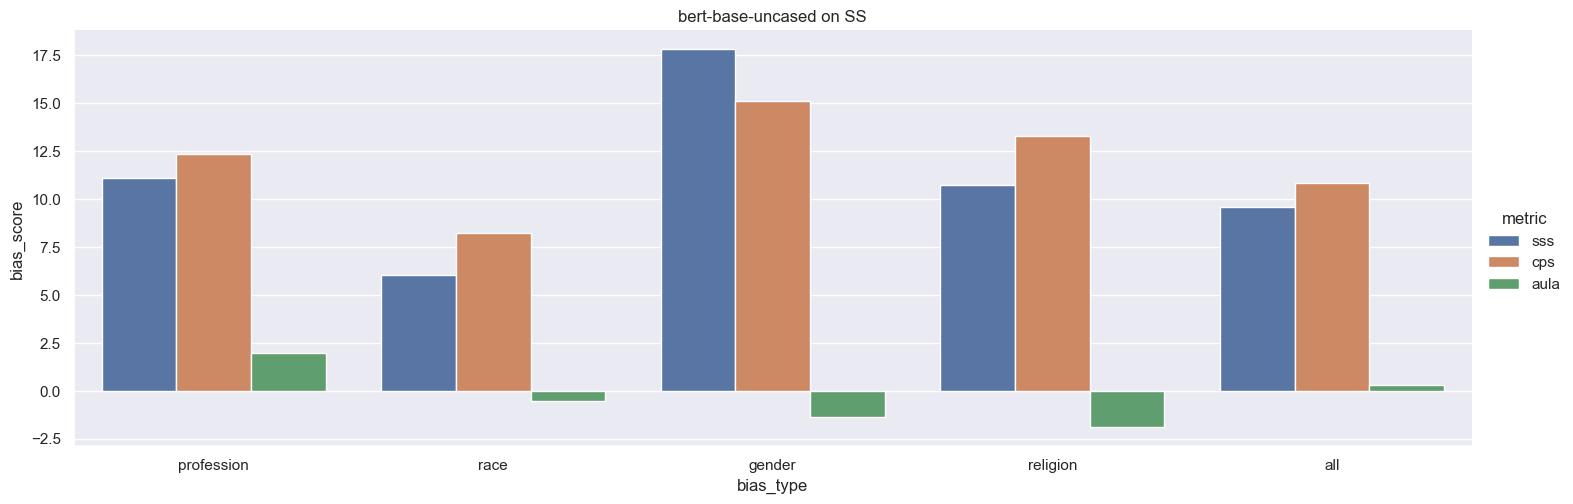

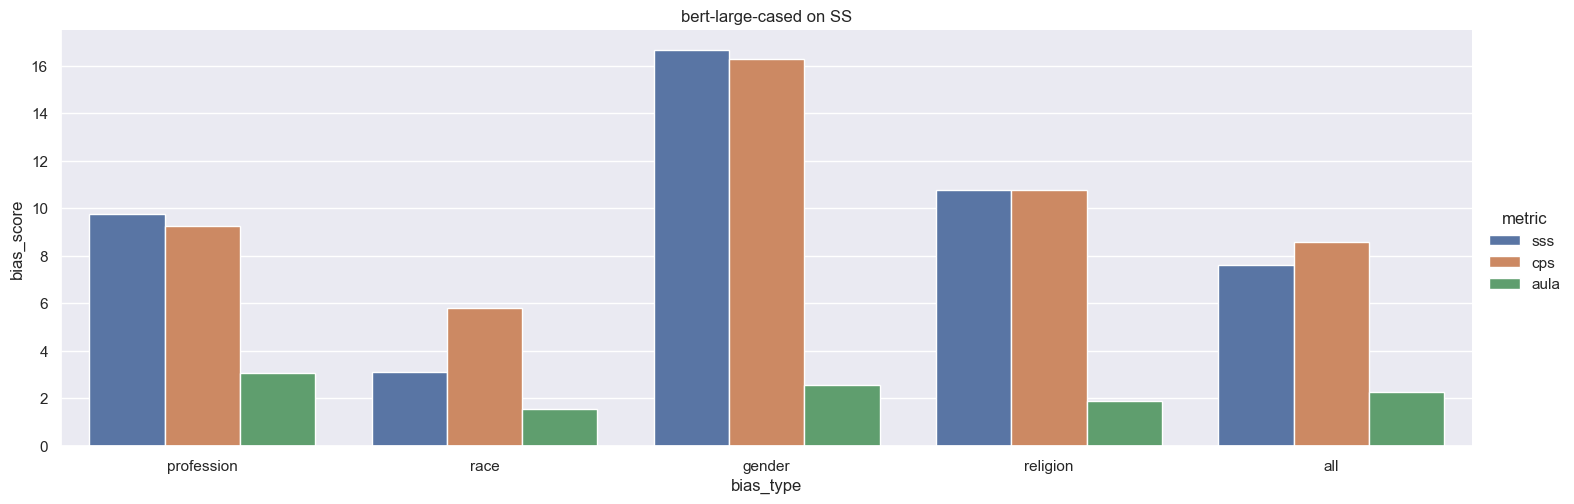

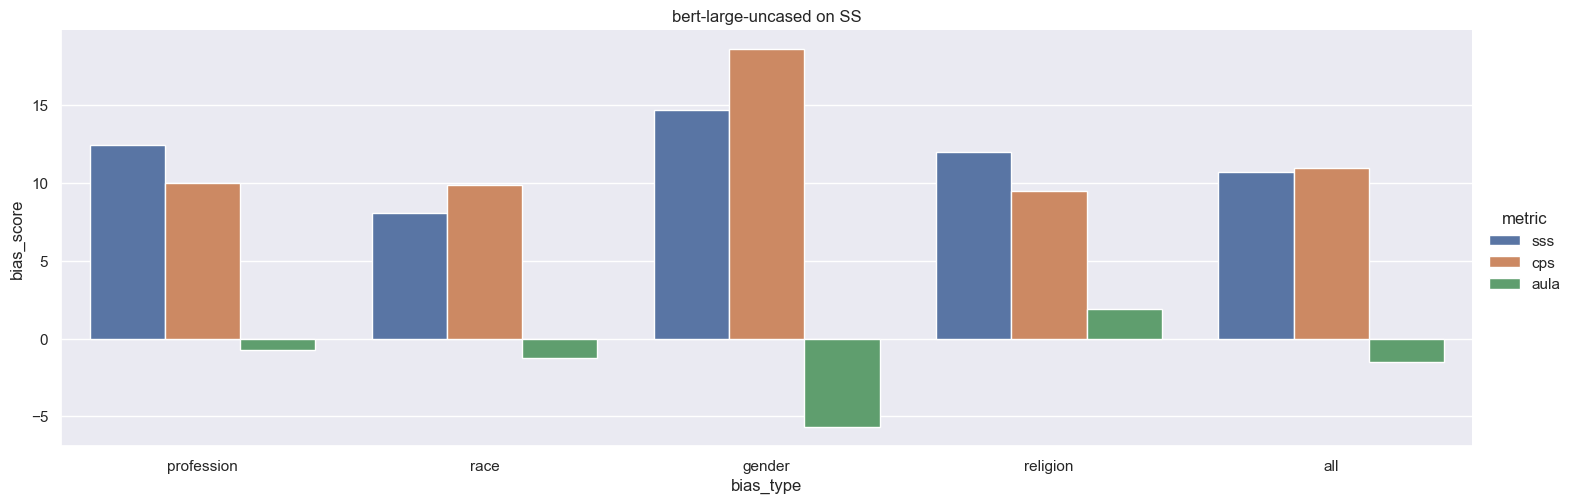

In [8]:
for m in models:
    sns.catplot(data=results[(results['data']=='ss') & (results['model']==m)],x='bias_type',y='bias_score', hue='metric', kind='bar', aspect=3.)
    plt.title(f'{m} on SS')
    plt.show()

# Extrinsic Bias
## STS-B
I only have results for BERT so far.

In [10]:
from scipy.stats import pearsonr

In [14]:
models = ['albert-base-v2', 'roberta-large', 'bert-base-cased', 'bert-base-uncased', 'bert-large-cased', 'bert-large-uncased']
occ_stats = pd.read_csv('data/STS/STS-B/occupations-stats.tsv', sep='\t')
pearson_corr = {}

for m in models:
    dataset = pd.read_csv(f'results/{m}/sts-bias.csv', names=['occupation','score'])
    corr, _ = pearsonr(occ_stats['bls_pct_female'], dataset['score'])
    pearson_corr[m] = corr
    

In [15]:
pearson_corr

{'albert-base-v2': 0.2314775794835891,
 'roberta-large': -0.3033425061372752,
 'bert-base-cased': -0.004457780090719871,
 'bert-base-uncased': -0.4928490390849405,
 'bert-large-cased': 0.05073919541111571,
 'bert-large-uncased': -0.4234013472826021}

# Debiased MLM
## Intrinsic


In [73]:
list_of_debiased = {
    'albert-base-v2': ['race'],
    'bert-base-uncased': ['race','gender'],
    'bert-base-cased': ['race'],
    'bert-large-cased': ['race'],
    'bert-large-uncased': ['race'],
    'roberta-large': ['race']
}

results = pd.DataFrame(columns=['data','model','metric','bias_type','bias_score'])

datasets = ['cp', 'ss']
metrics = ['sss', 'cps', 'aula']
bias_type = {
    'cp': ['race-color', 'socioeconomic', 'gender', 'disability',
       'nationality', 'sexual-orientation', 'physical-appearance',
       'religion', 'age', 'all'],
    'ss': ['profession', 'race', 'gender', 'religion', 'all'],
    
}

for data in datasets:
    for m in list_of_debiased:
        for met in metrics:
            ds = pd.read_csv(f'results/{m}/{met}_{data}.csv')
            for b in bias_type[data]:
                new_row = {
                    'data': data,
                    'model': m,
                    'type': 'original',
                    'metric': met,
                    'bias_type': b.replace('-','\n'),
                    'bias_score': (100/len(ds[ds['bias_type']==b]['st>at']))*(ds[ds['bias_type']==b]['st>at'].sum())-50 if b!='all' else (100/len(ds['st>at']))*ds['st>at'].sum()-50
                    # 'bias_score': ds[ds['bias_type']==b]['st>at'].mean() if b!='all' else ds['st>at'].mean()
                }

                results = pd.concat([results, pd.DataFrame(new_row, index=[0])], ignore_index=True)

            for bt in list_of_debiased[m]:
                ds = pd.read_csv(f'results/{m}/{met}_{data}_{bt}.csv')
                for b in bias_type[data]:
                    new_row = {
                        'data': data,
                        'model': m,
                        'type': f'debiased-{bt}',
                        'metric': met,
                        'bias_type': b.replace('-','\n'),
                        'bias_score': (100/len(ds[ds['bias_type']==b]['st>at']))*(ds[ds['bias_type']==b]['st>at'].sum())-50 if b!='all' else (100/len(ds['st>at']))*ds['st>at'].sum()-50
                        # 'bias_score': ds[ds['bias_type']==b]['st>at'].mean() if b!='all' else ds['st>at'].mean()
                    }

                    results = pd.concat([results, pd.DataFrame(new_row, index=[0])], ignore_index=True)
            



## CP

Text(0.5, 1.05, 'CP')

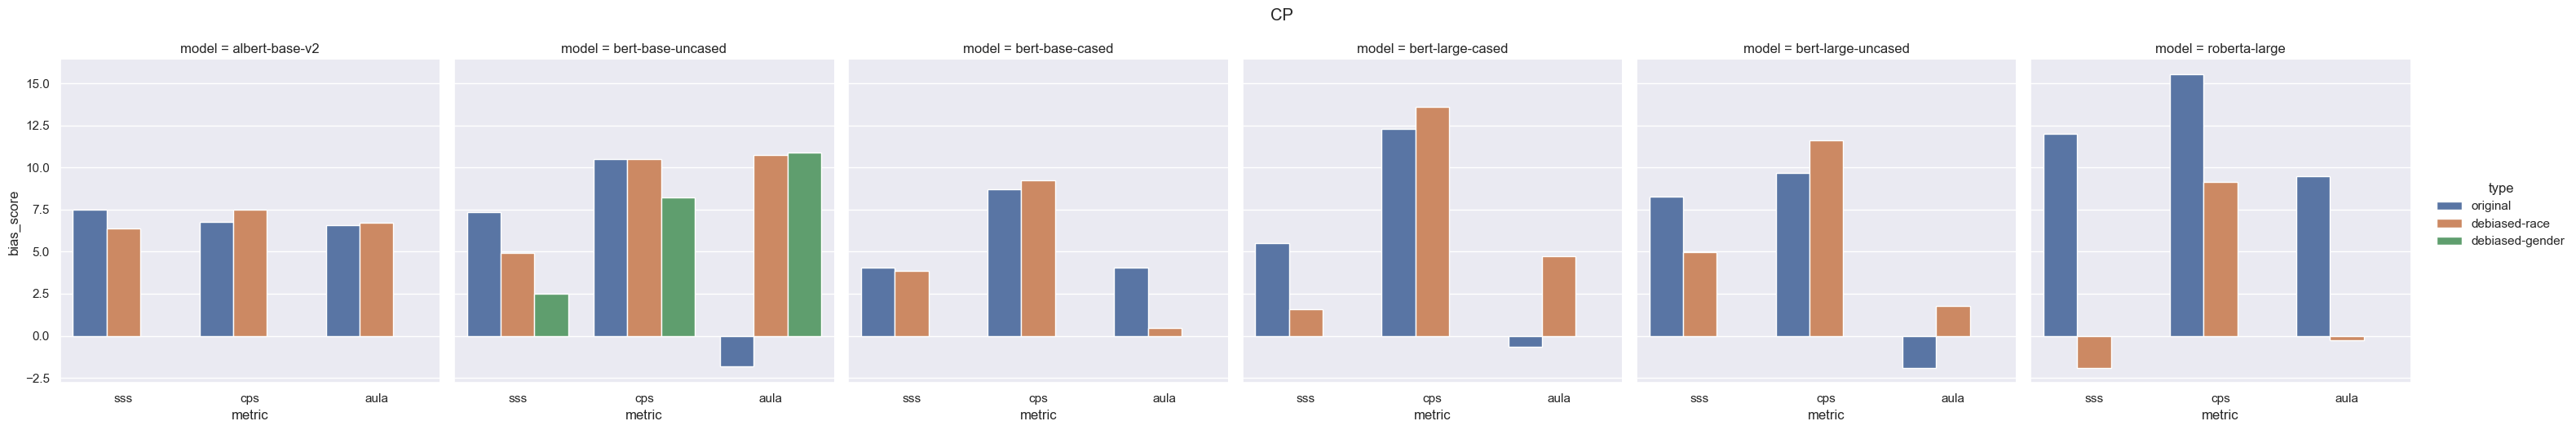

In [74]:
g = sns.catplot(data=results[(results['data']=='cp') & (results['bias_type']=='all')],x='metric',y='bias_score', col='model', hue='type', kind='bar')
g.fig.suptitle(f'CP', y=1.05)

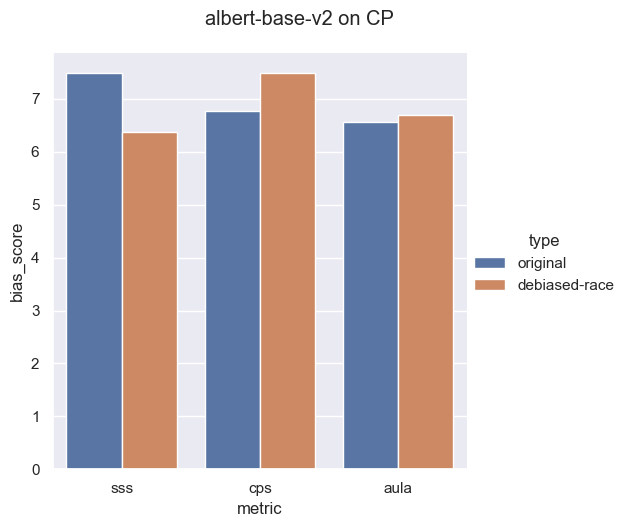

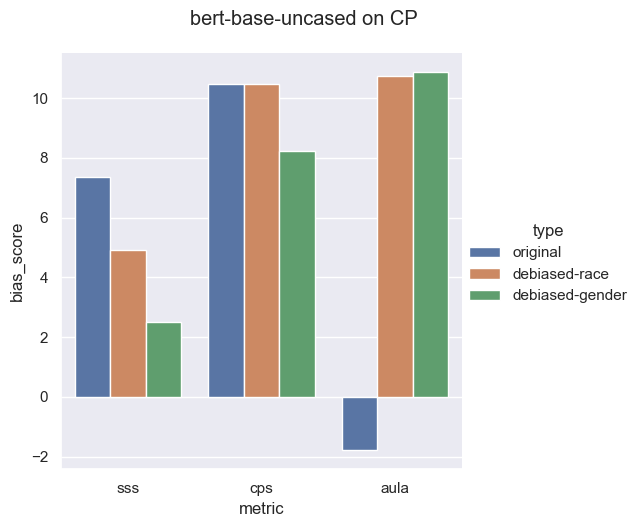

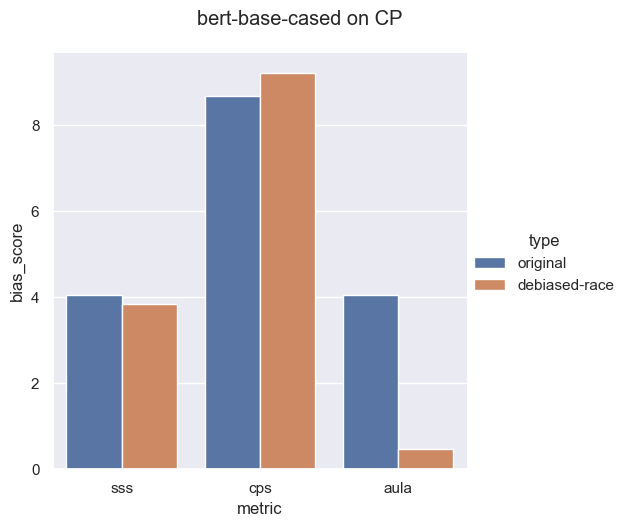

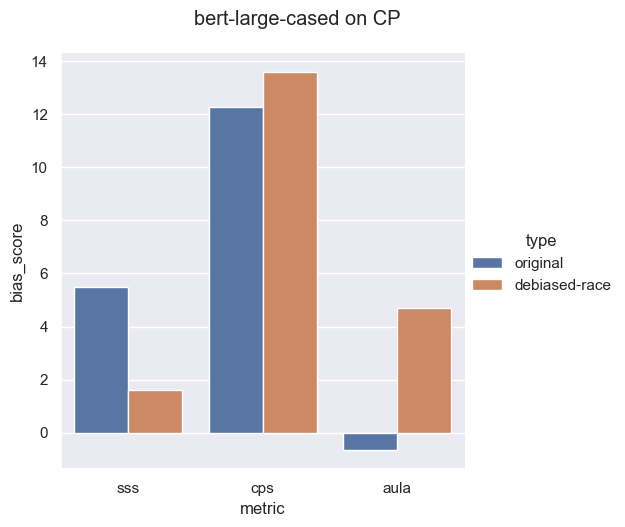

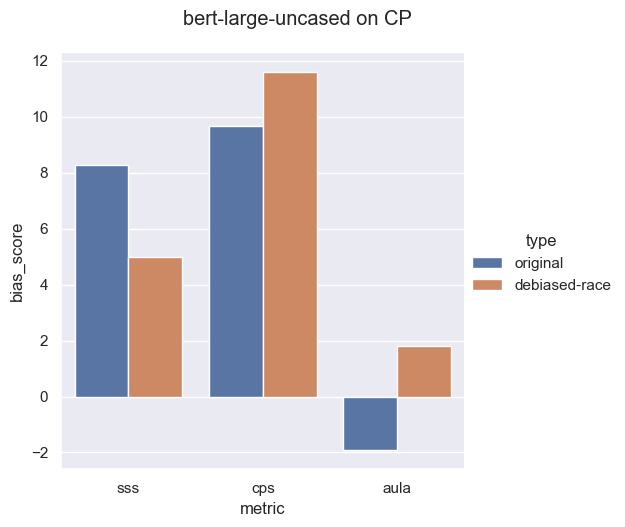

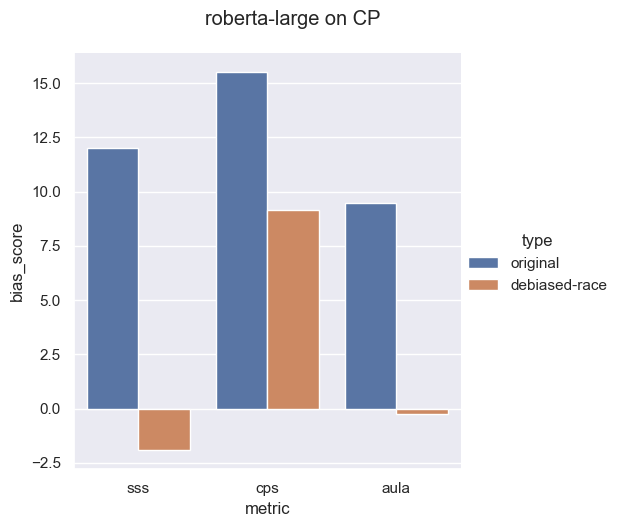

In [75]:
for m in list_of_debiased:
    g = sns.catplot(data=results[(results['data']=='cp') & (results['model']==m) & (results['bias_type']=='all')],x='metric',y='bias_score', hue='type', kind='bar')
    g.fig.suptitle(f'{m} on CP', y=1.05)
    # plt.ylim(-20,40)

    plt.show()
# g = sns.catplot(data=results[results['bias_type']=='all'],kind='bar',x='metric',y='bias_score', hue='data', row='model', col='type')
# plt.show()

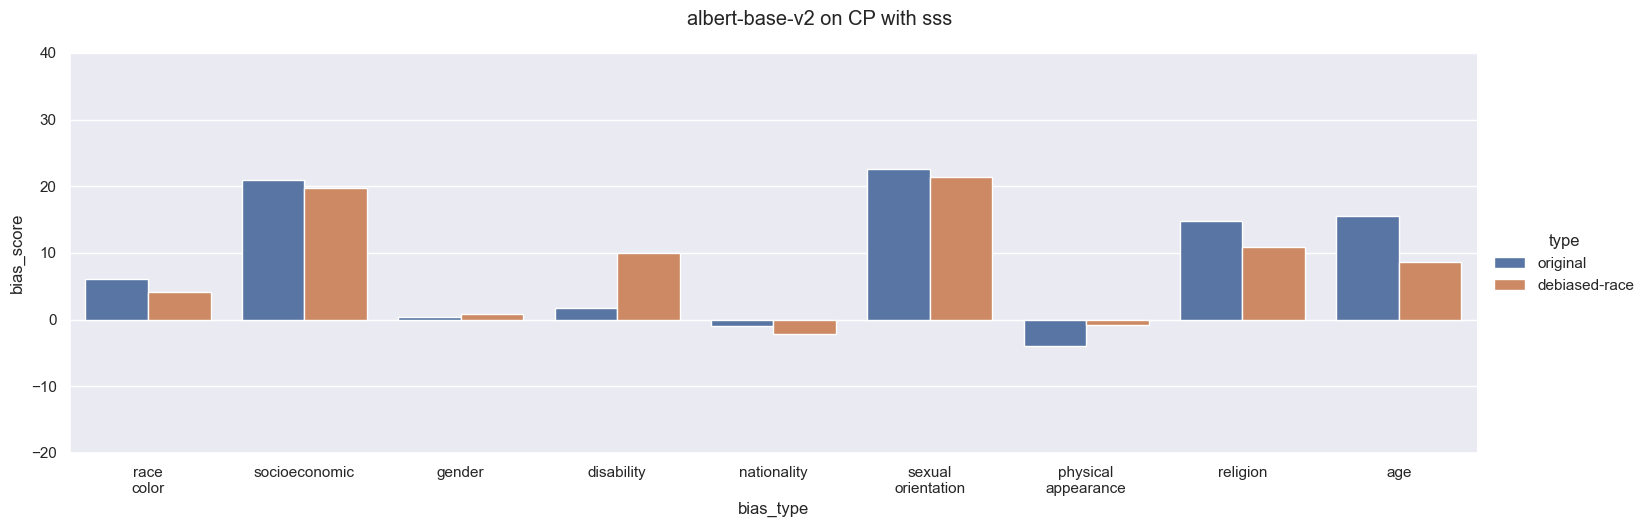

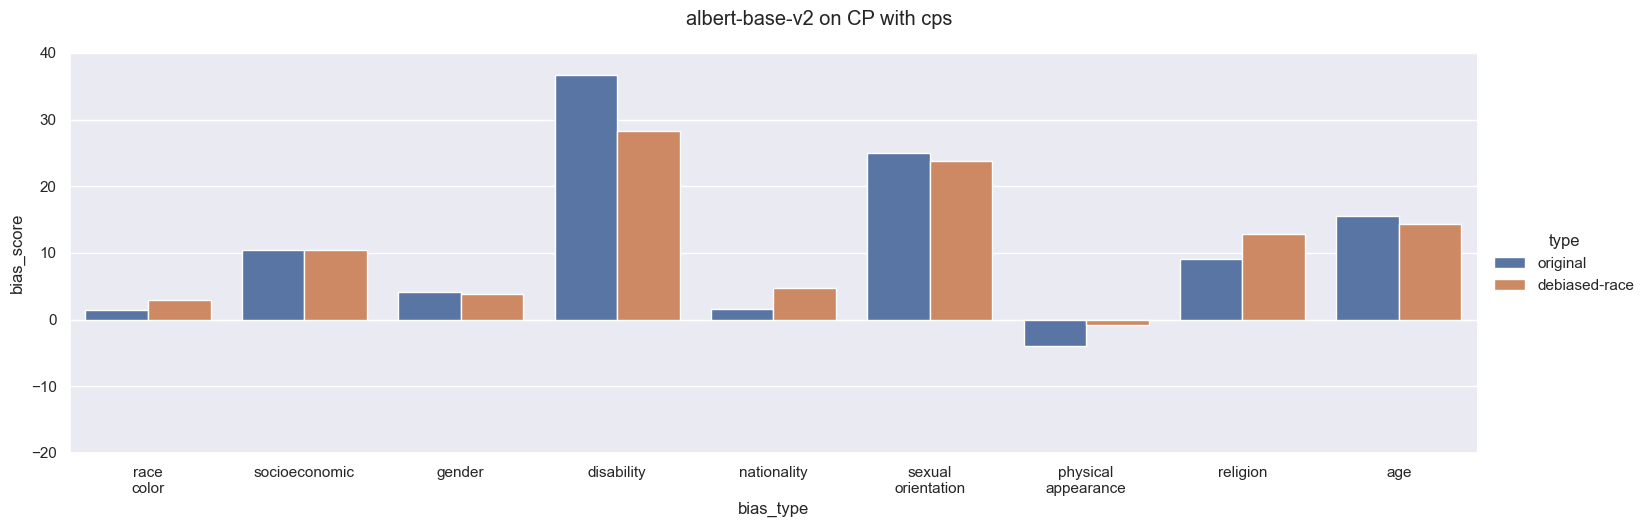

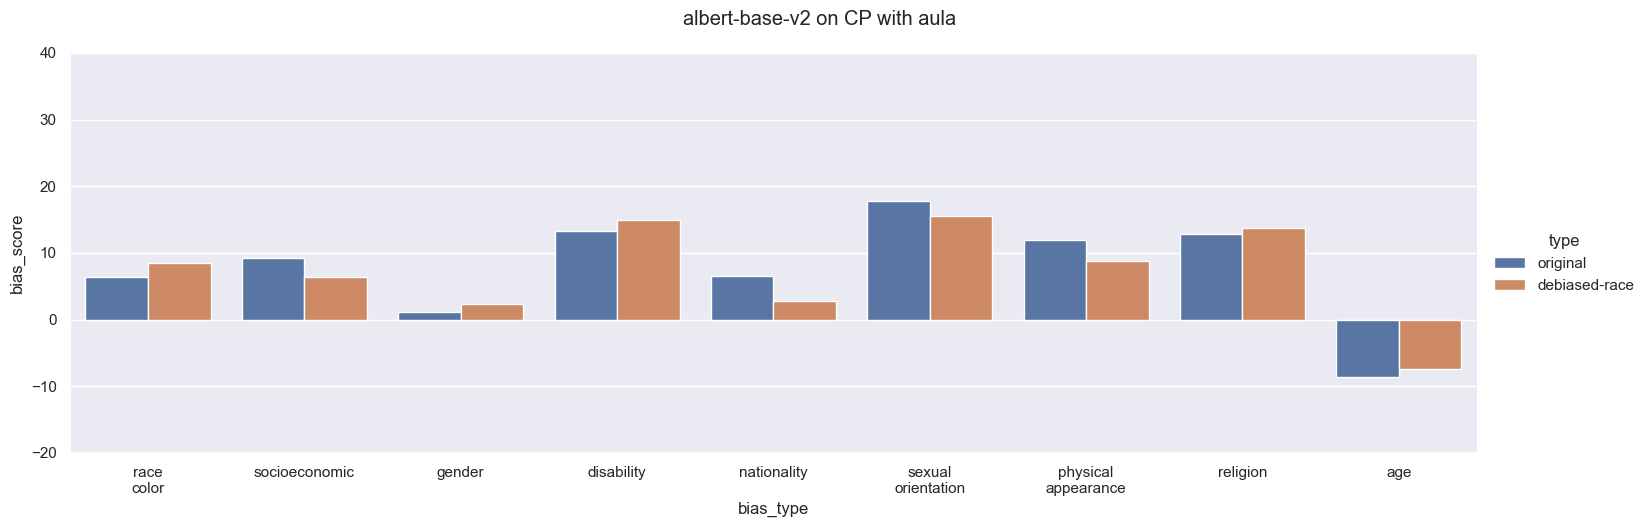

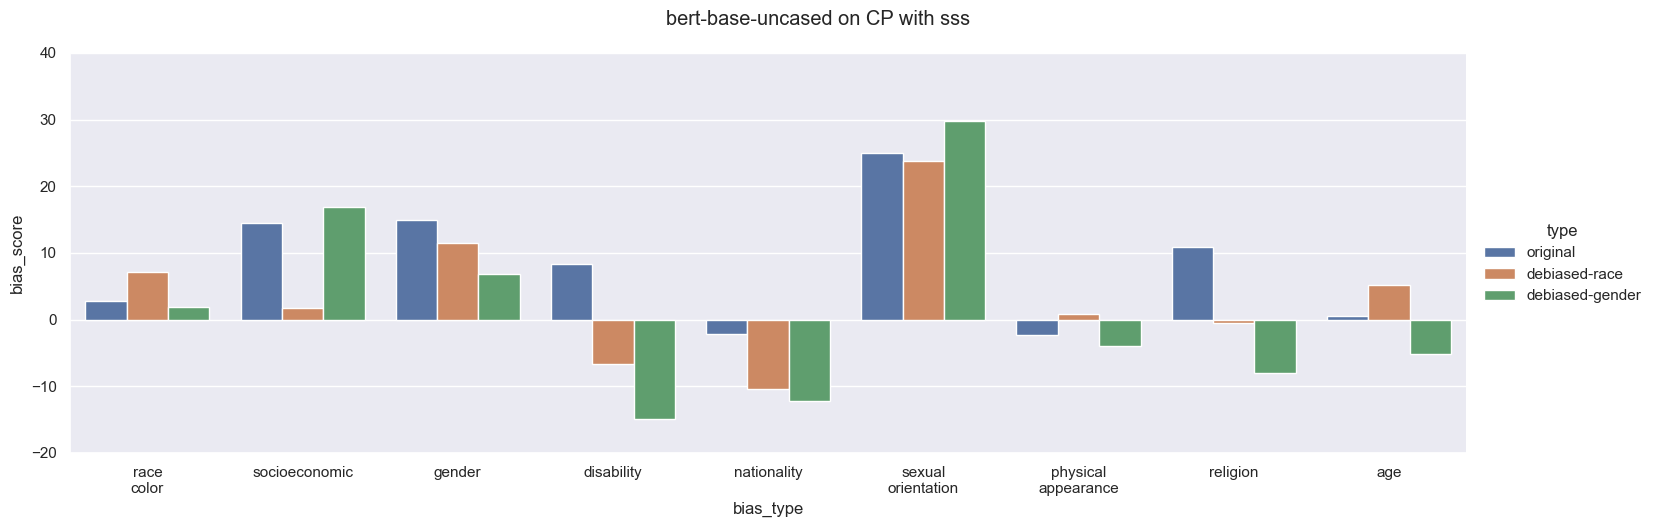

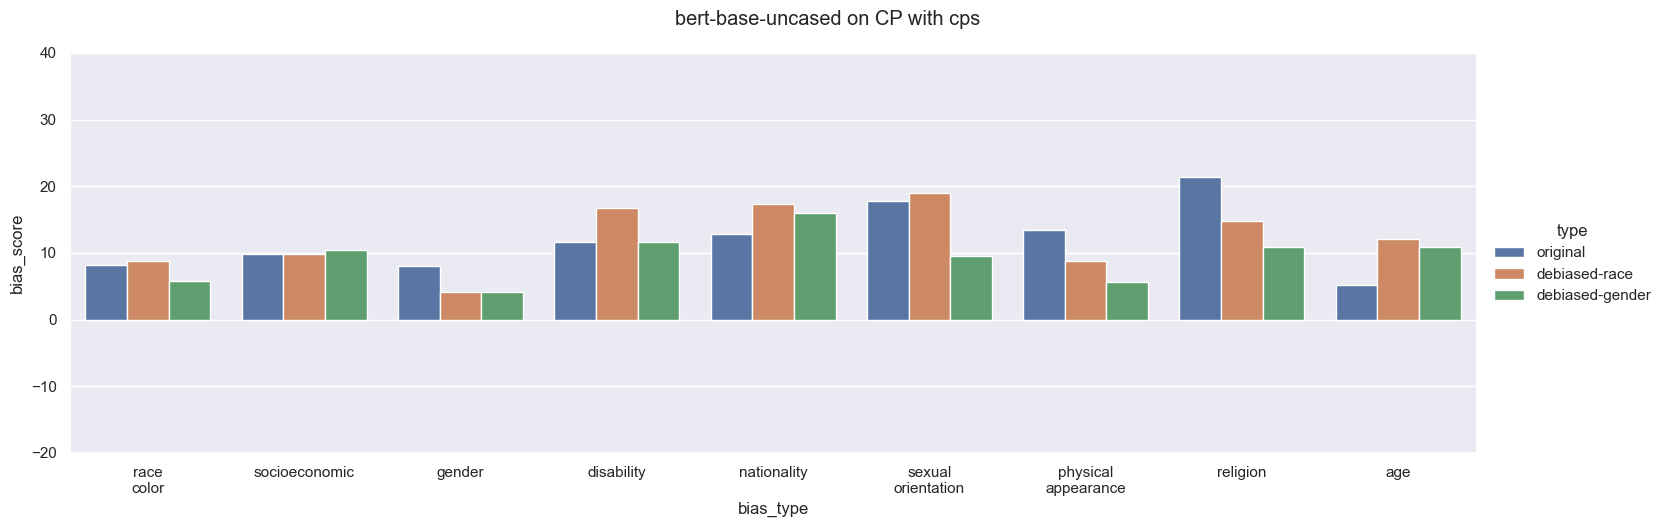

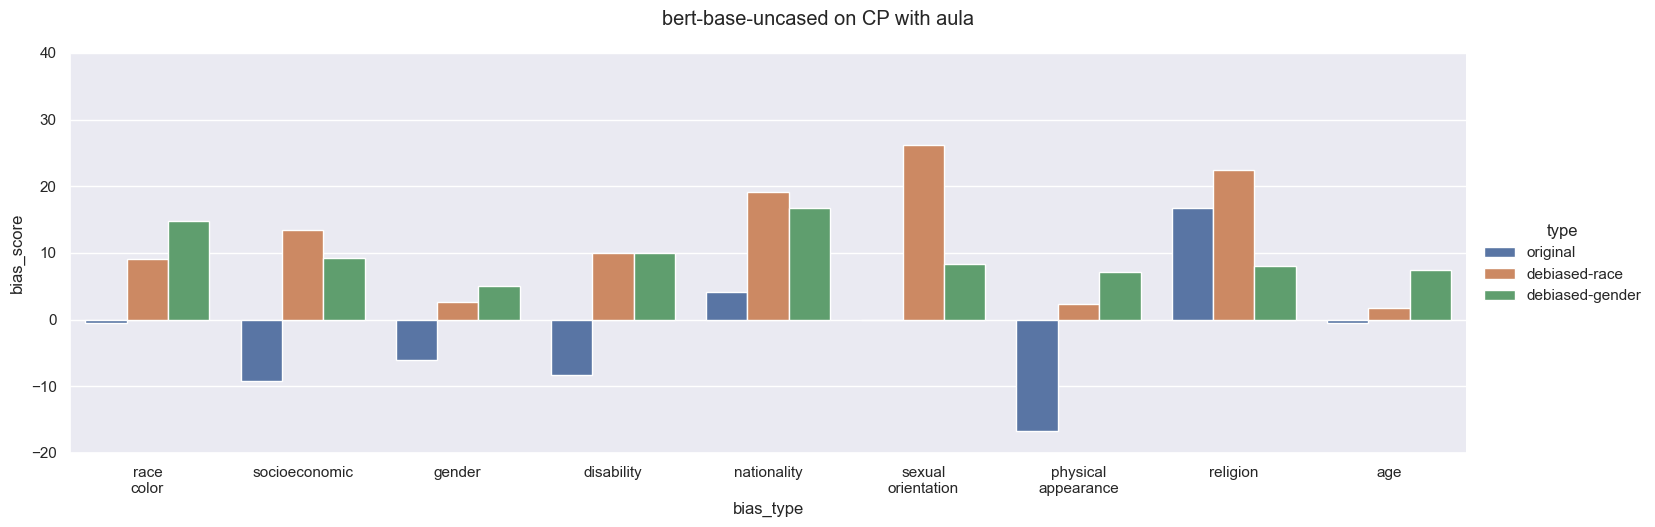

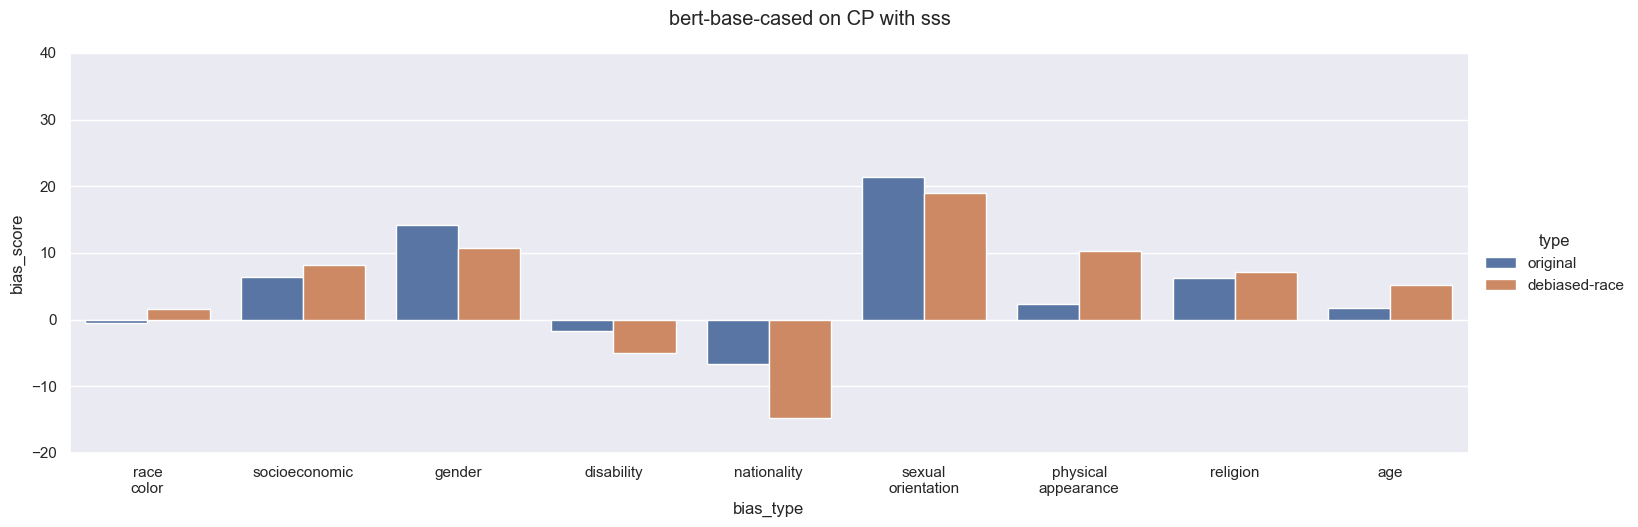

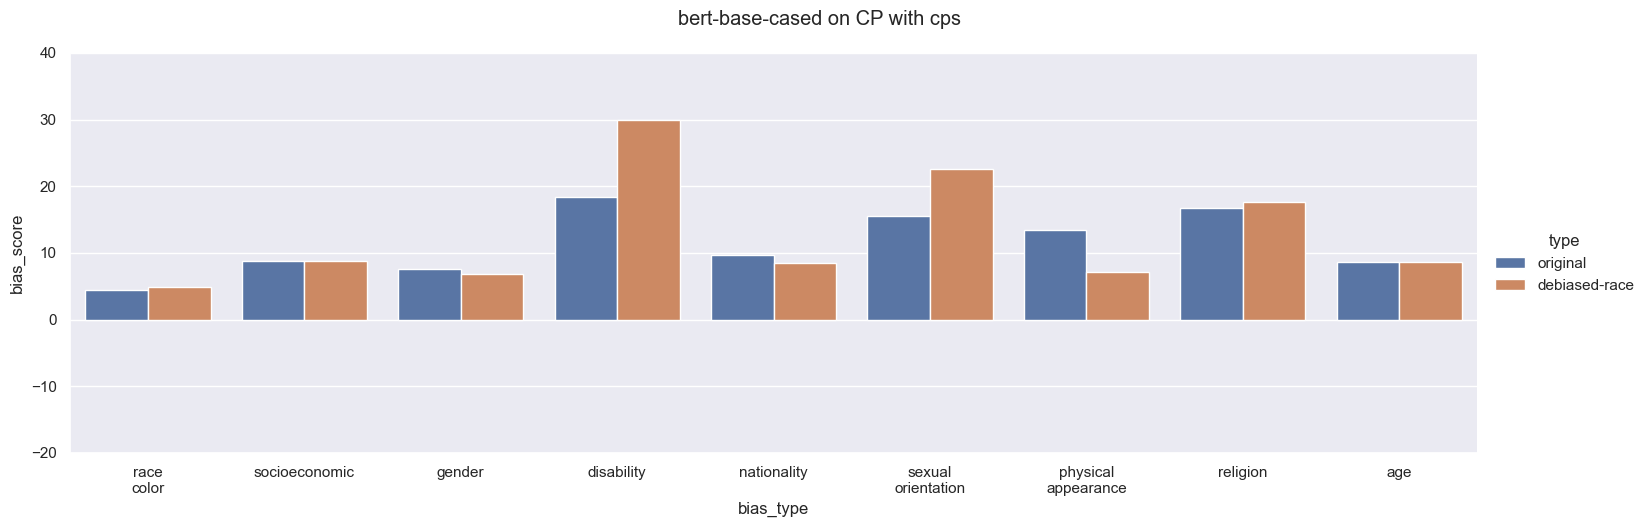

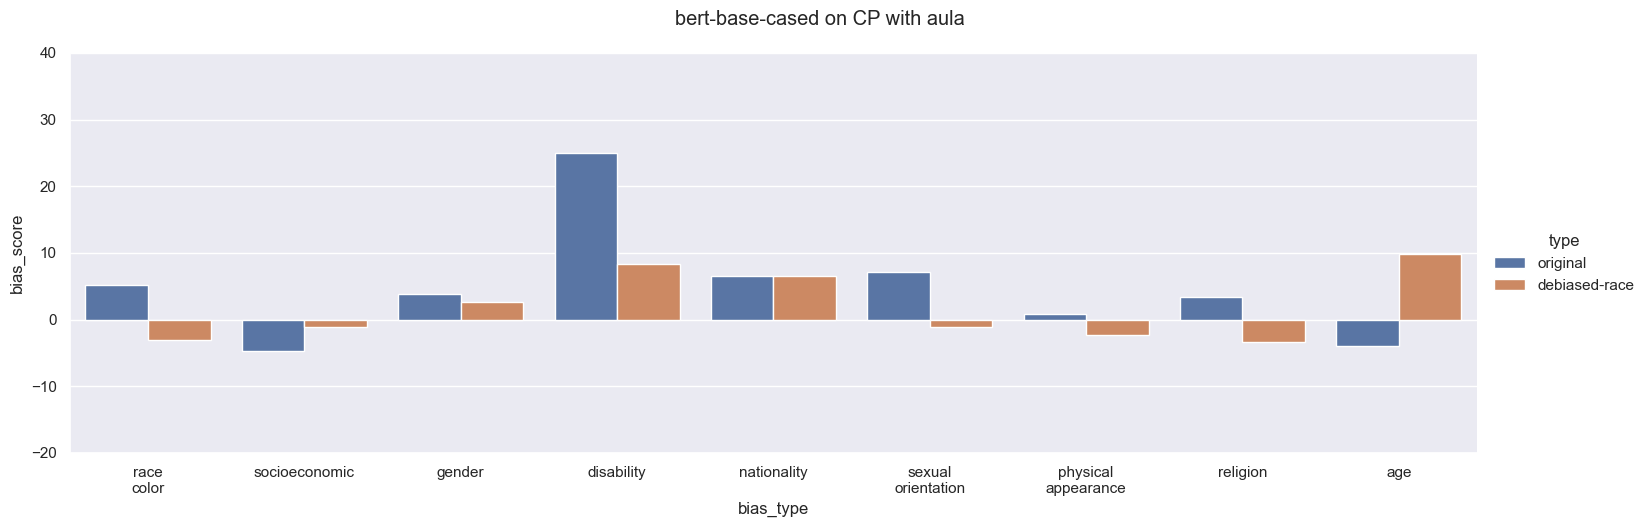

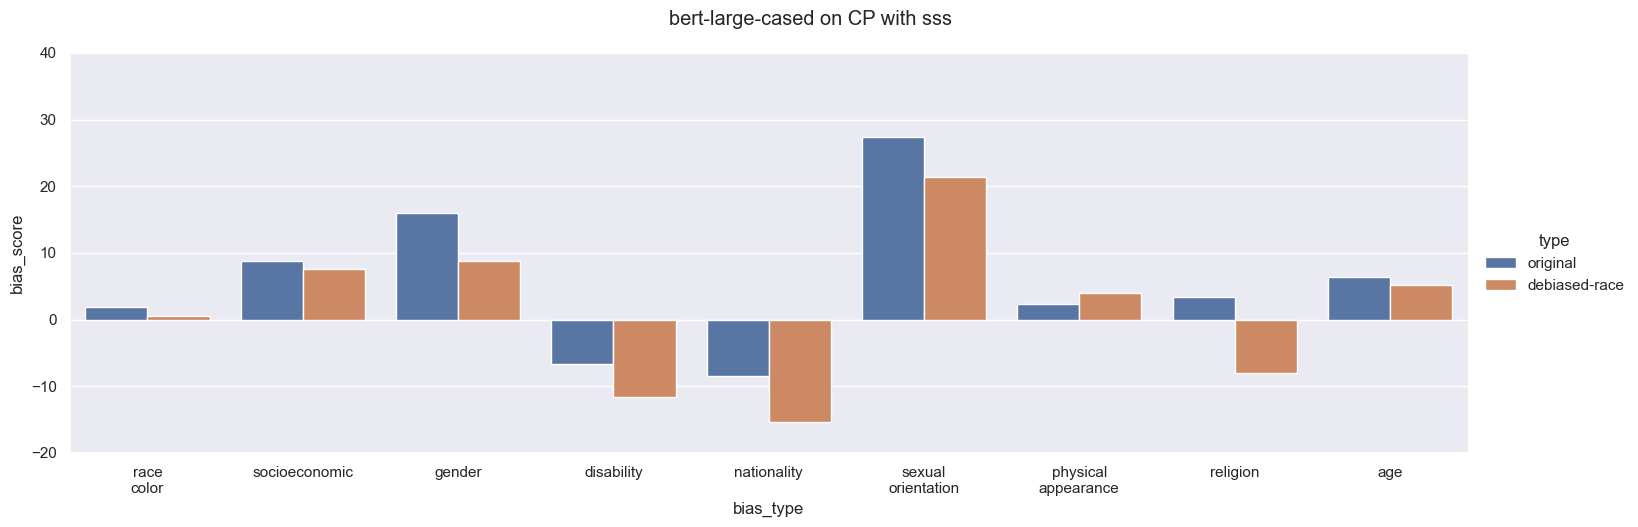

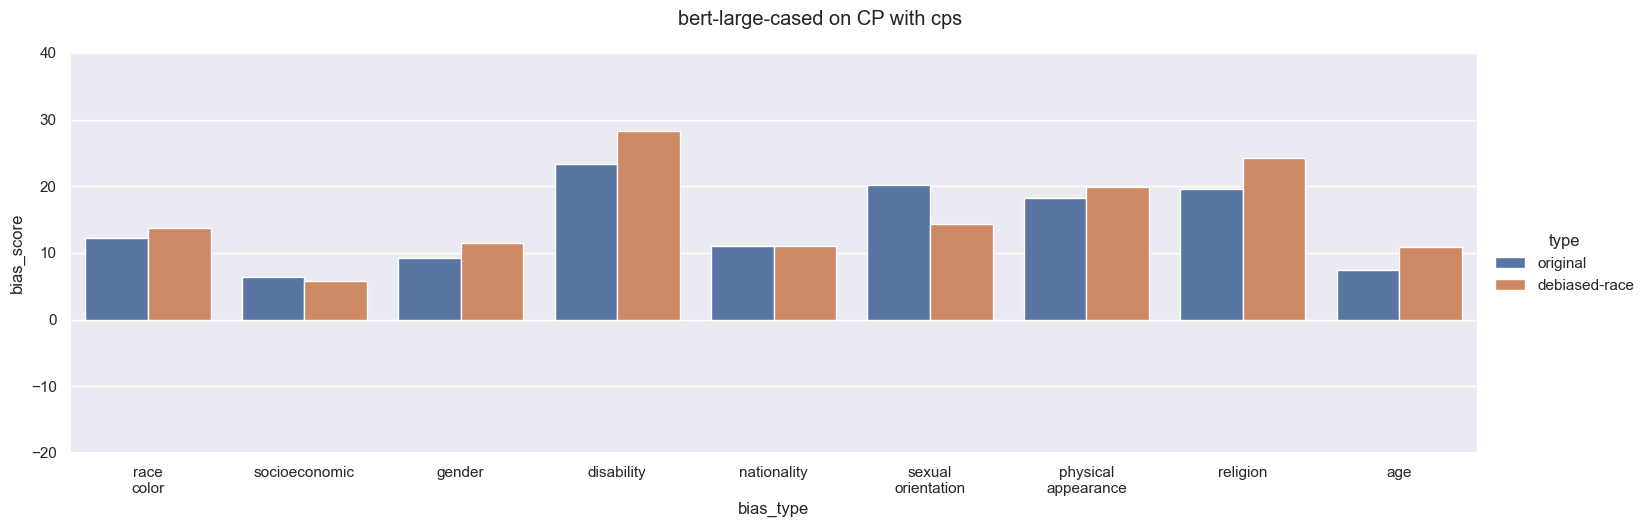

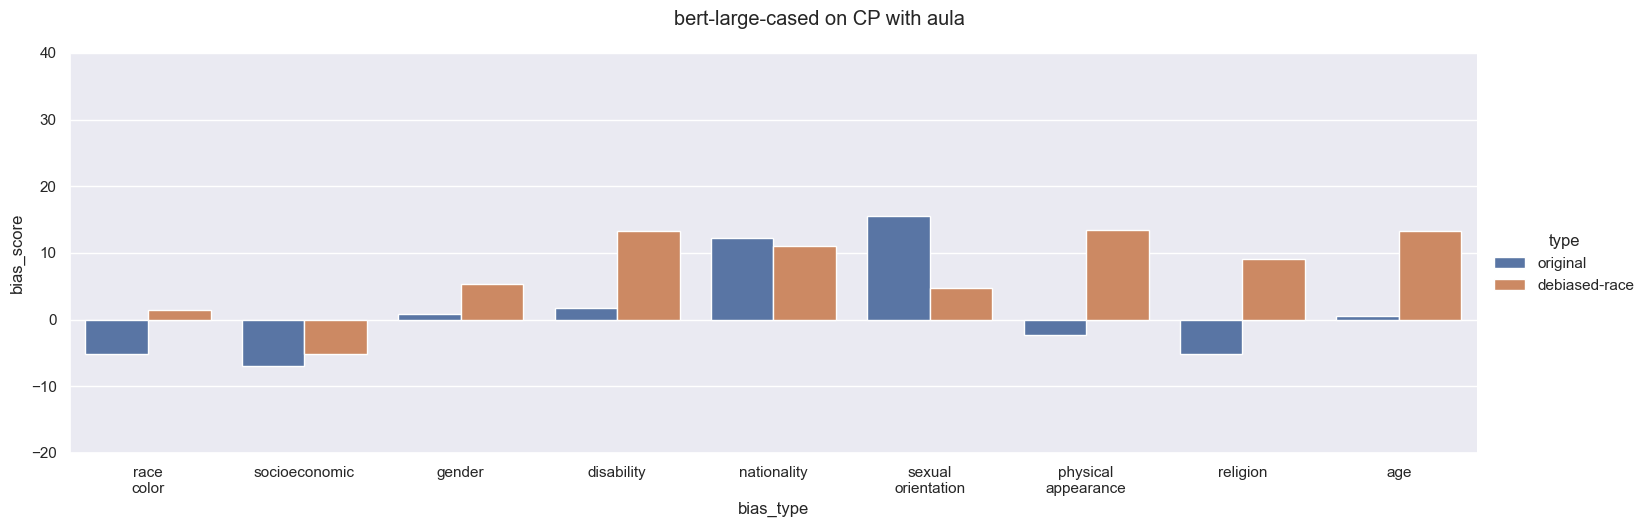

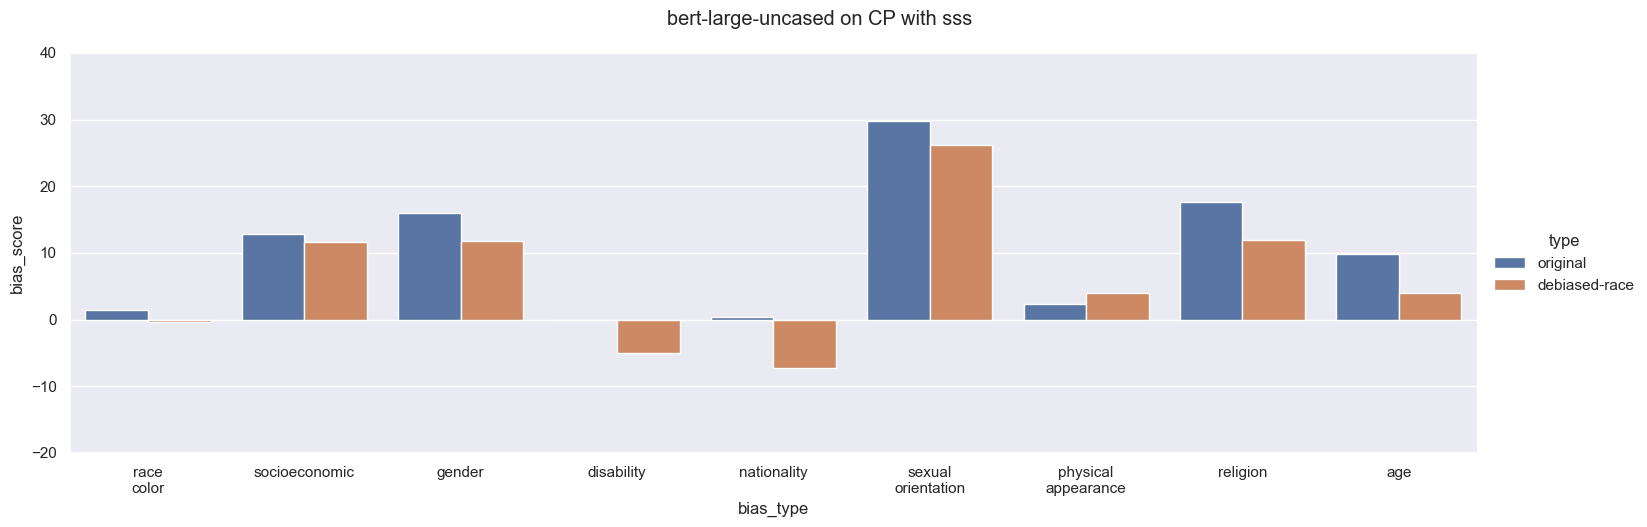

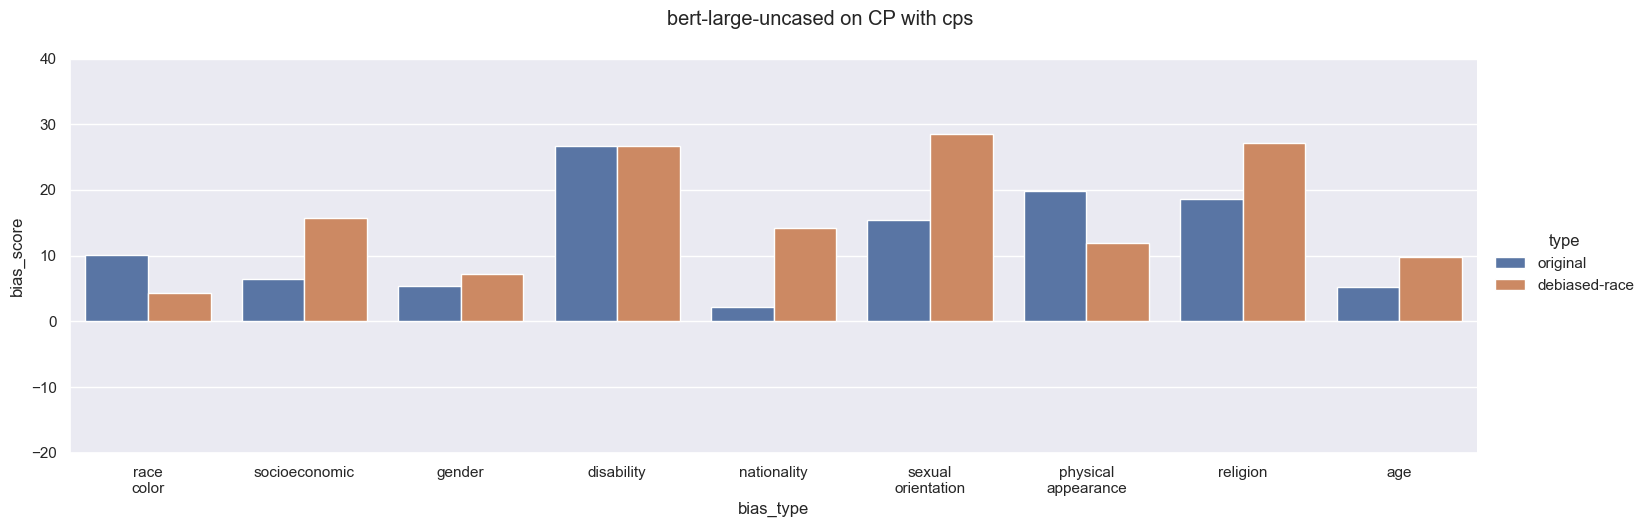

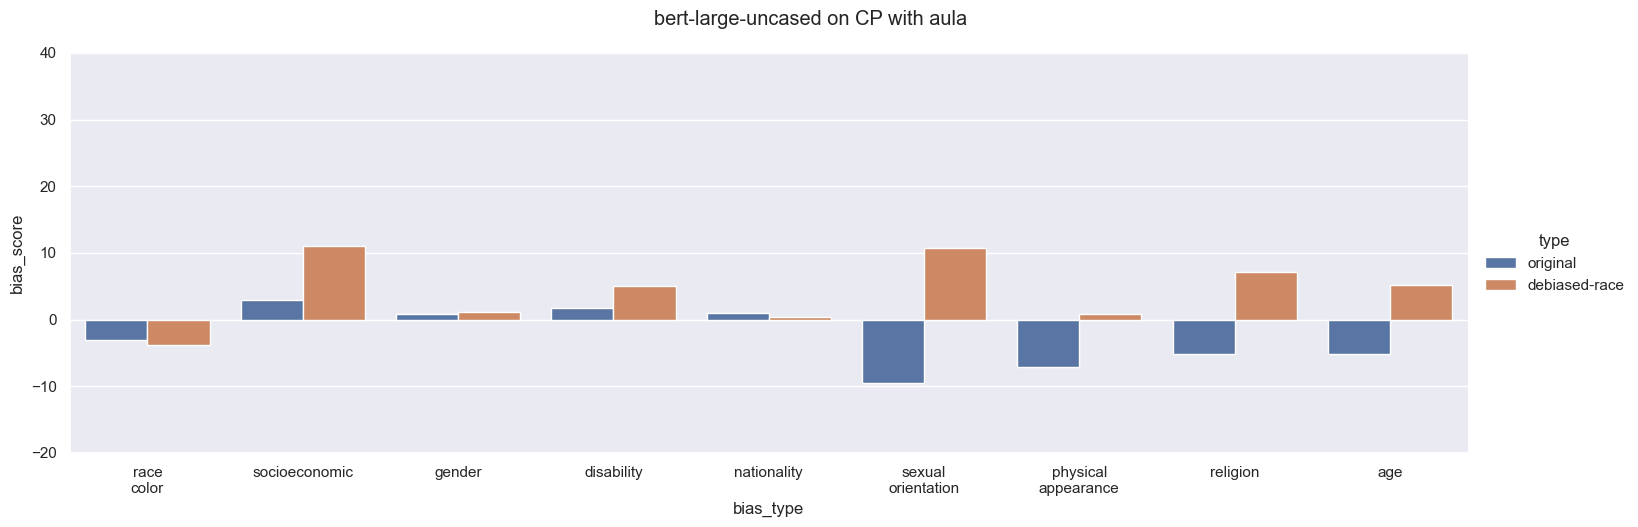

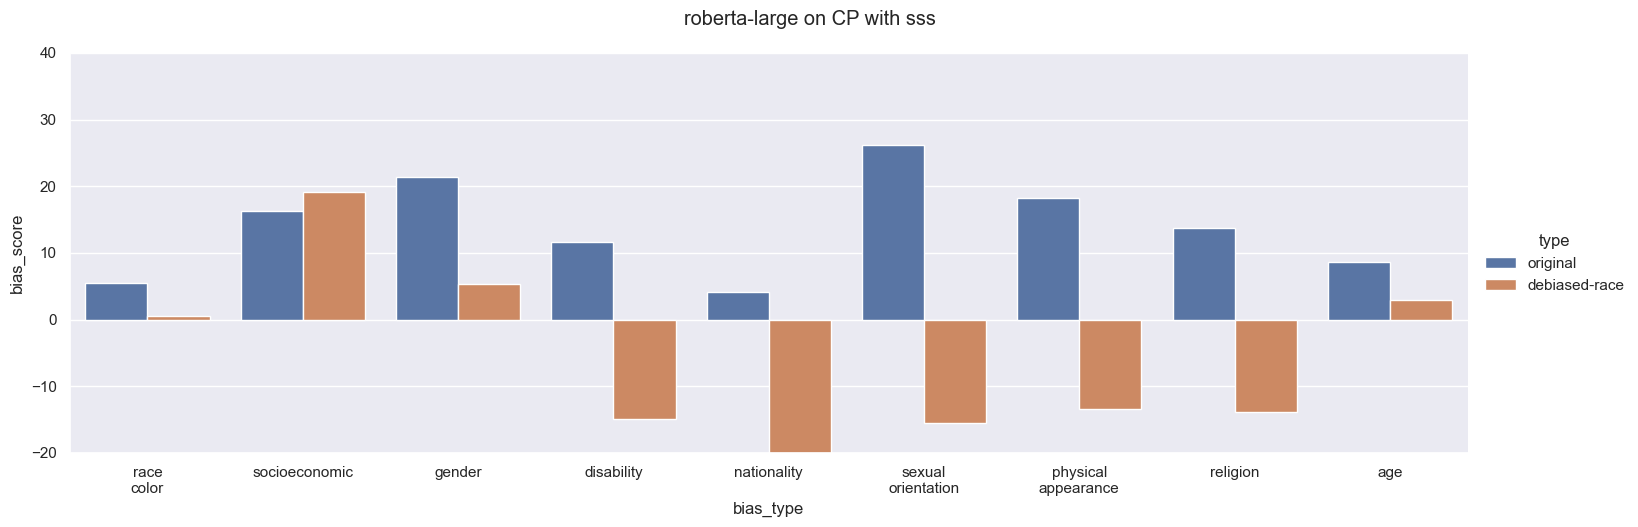

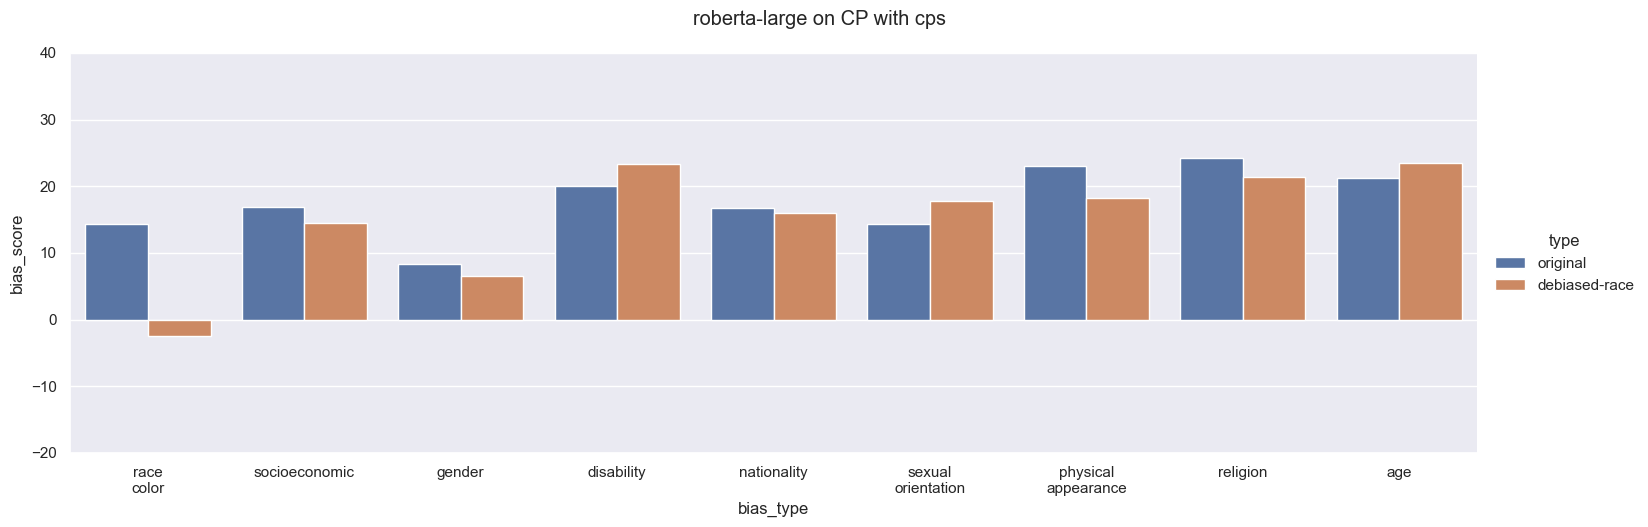

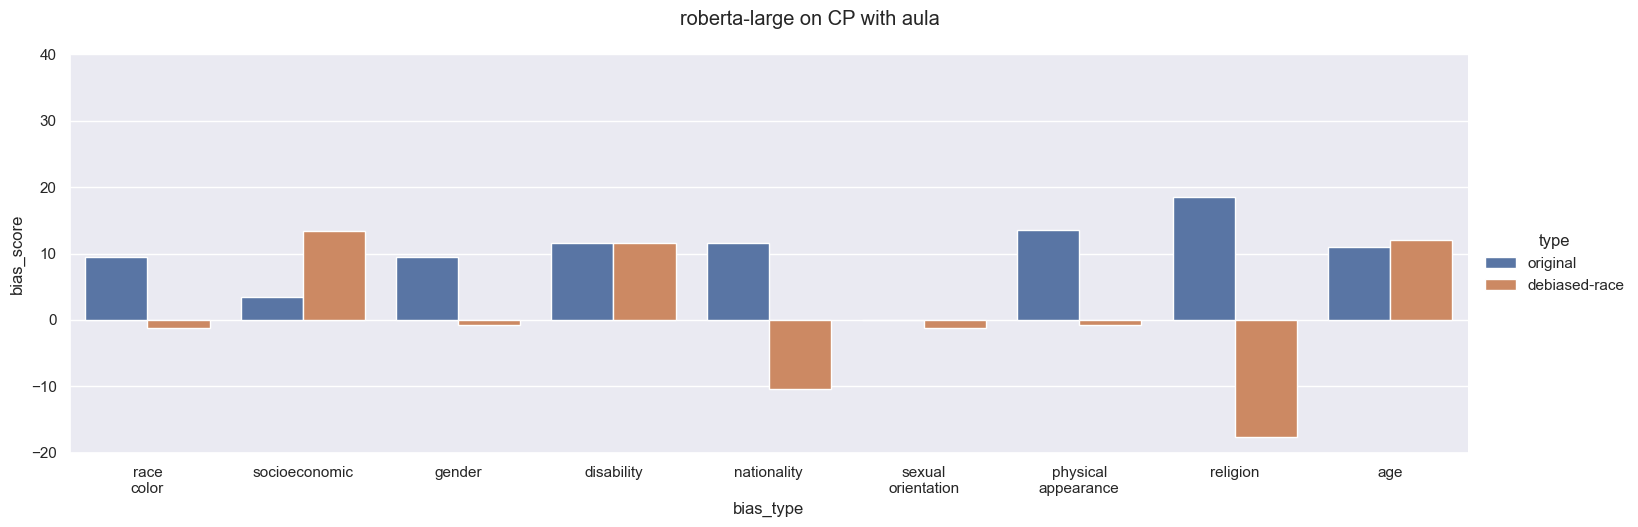

In [76]:
for m in list_of_debiased:
    for met in metrics:
        g = sns.catplot(data=results[(results['data']=='cp') & (results['model']==m) & (results['bias_type']!='all') & (results['metric']==met)],x='bias_type',y='bias_score', hue='type',kind='bar', aspect=3.)
        g.fig.suptitle(f'{m} on CP with {met}', y=1.05)
        plt.ylim(-20,40)

        plt.show()

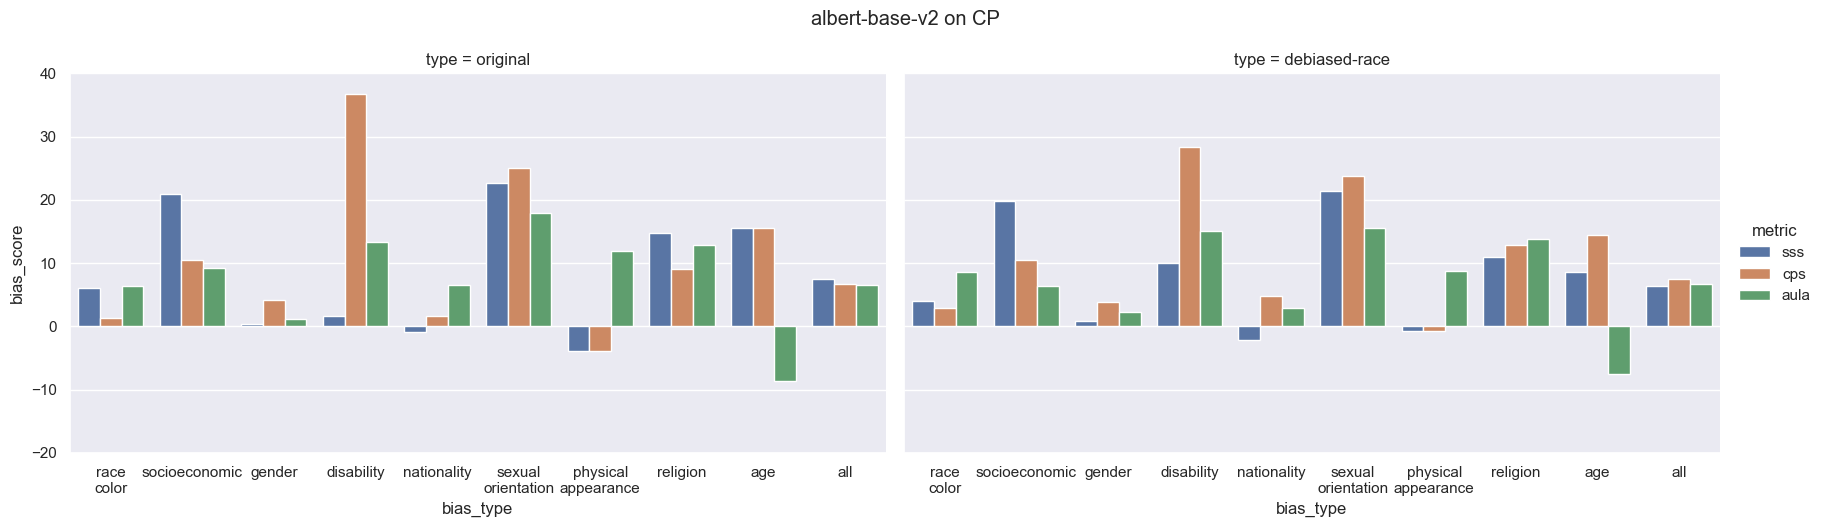

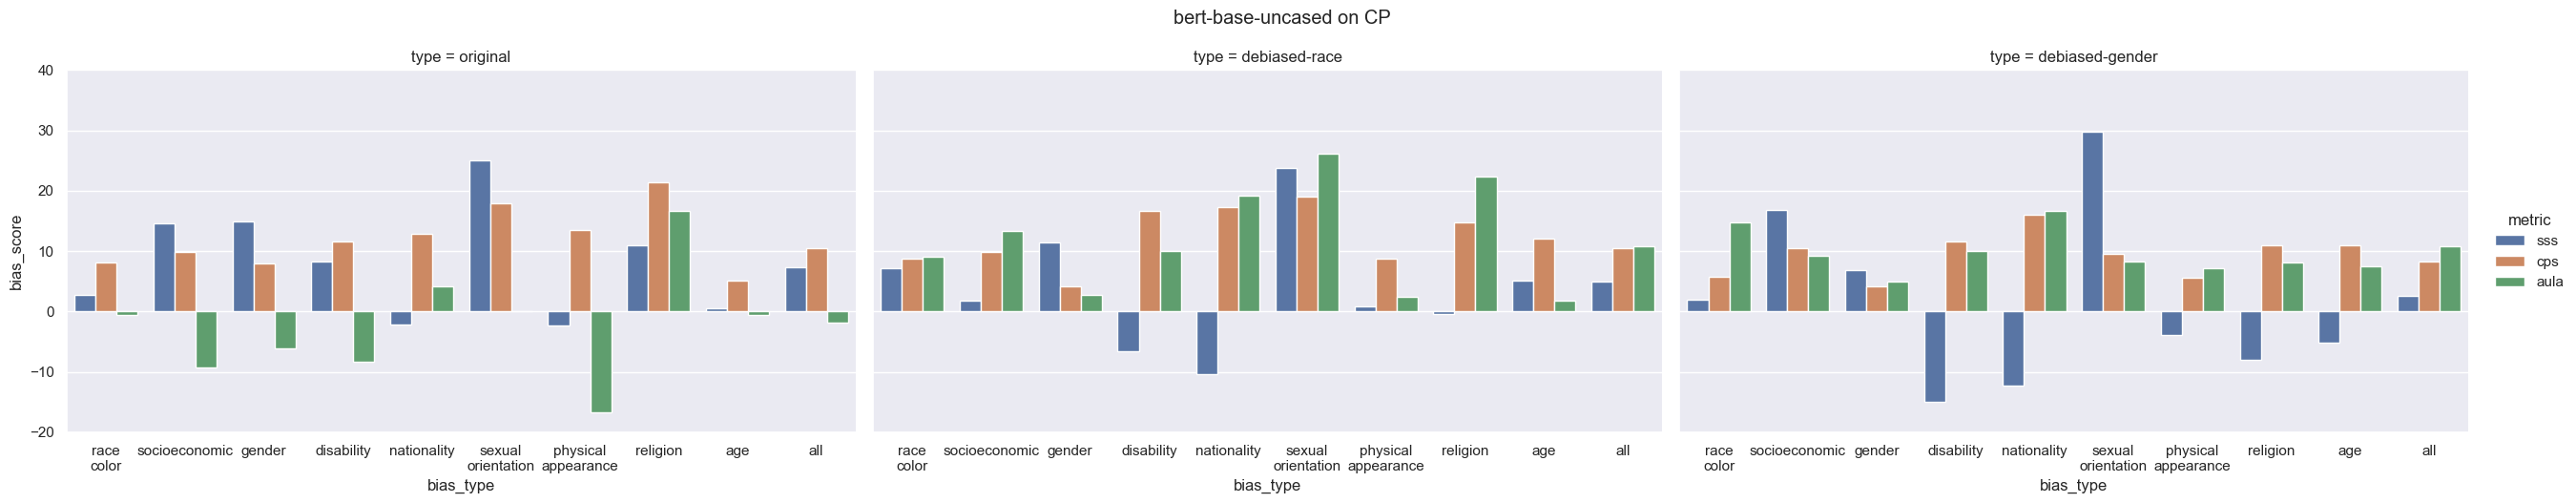

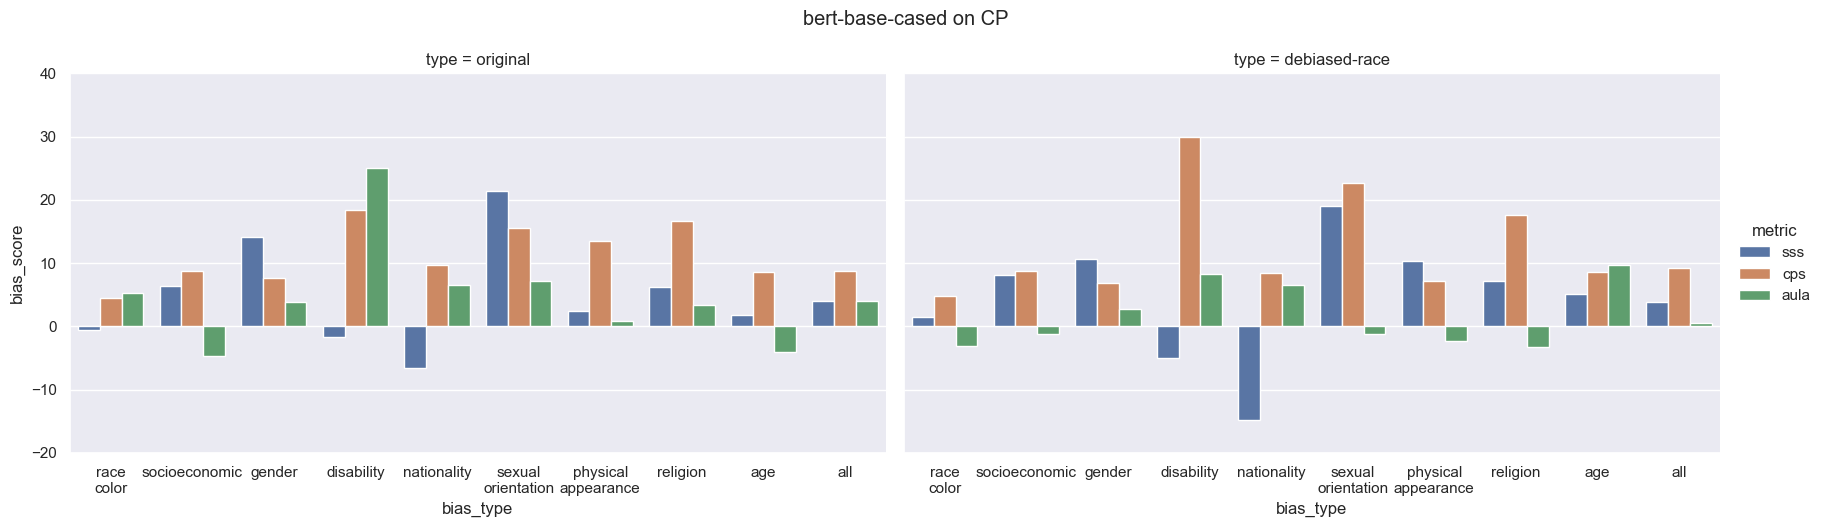

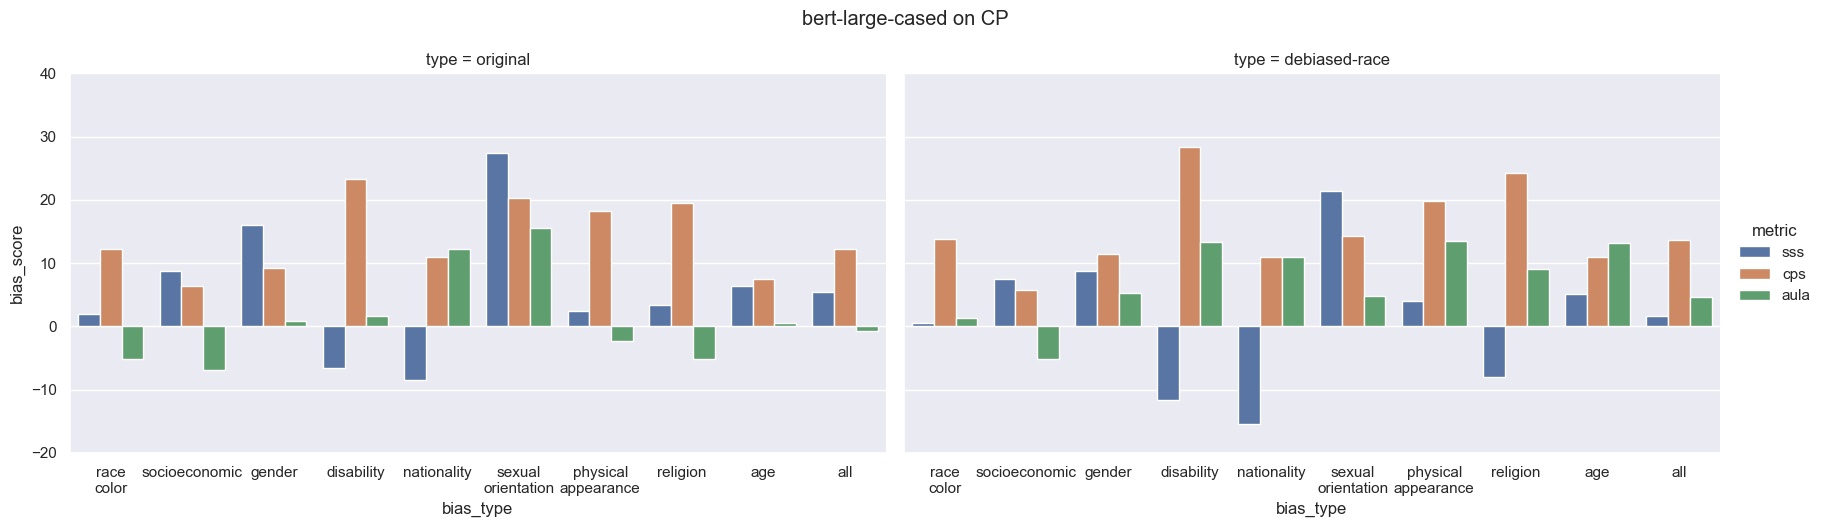

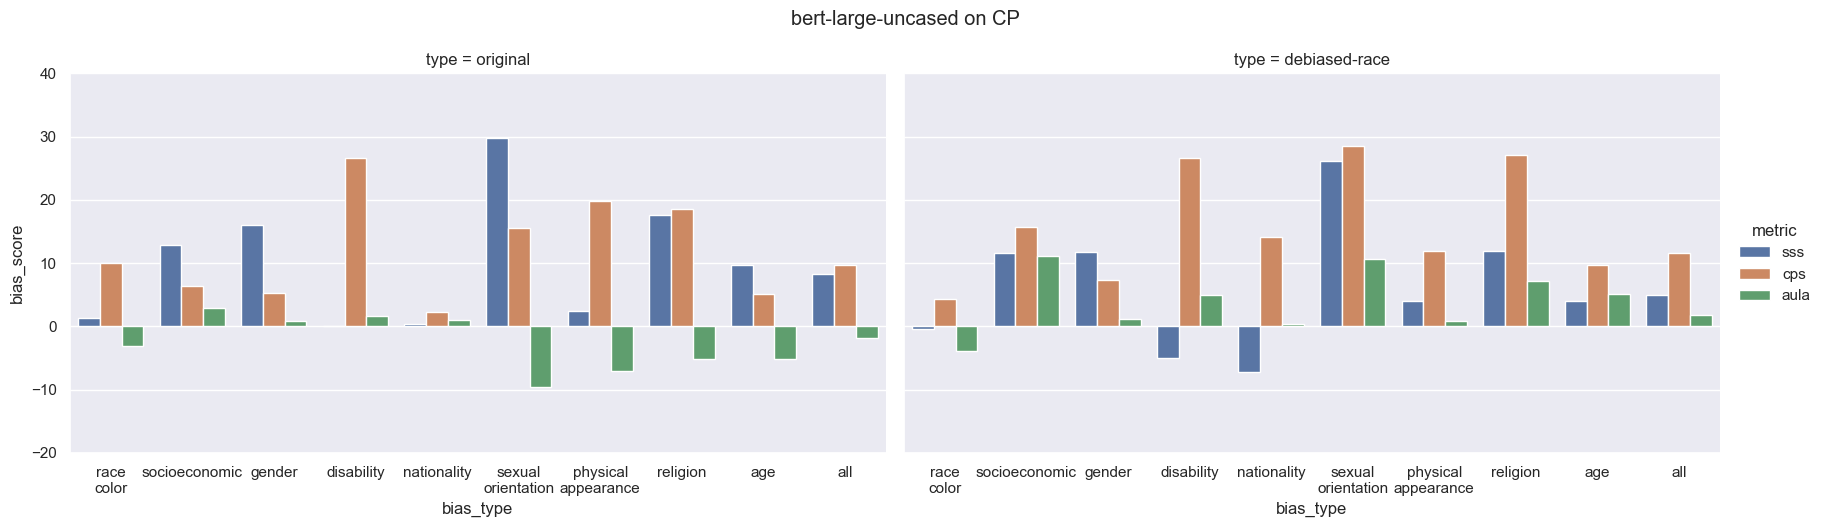

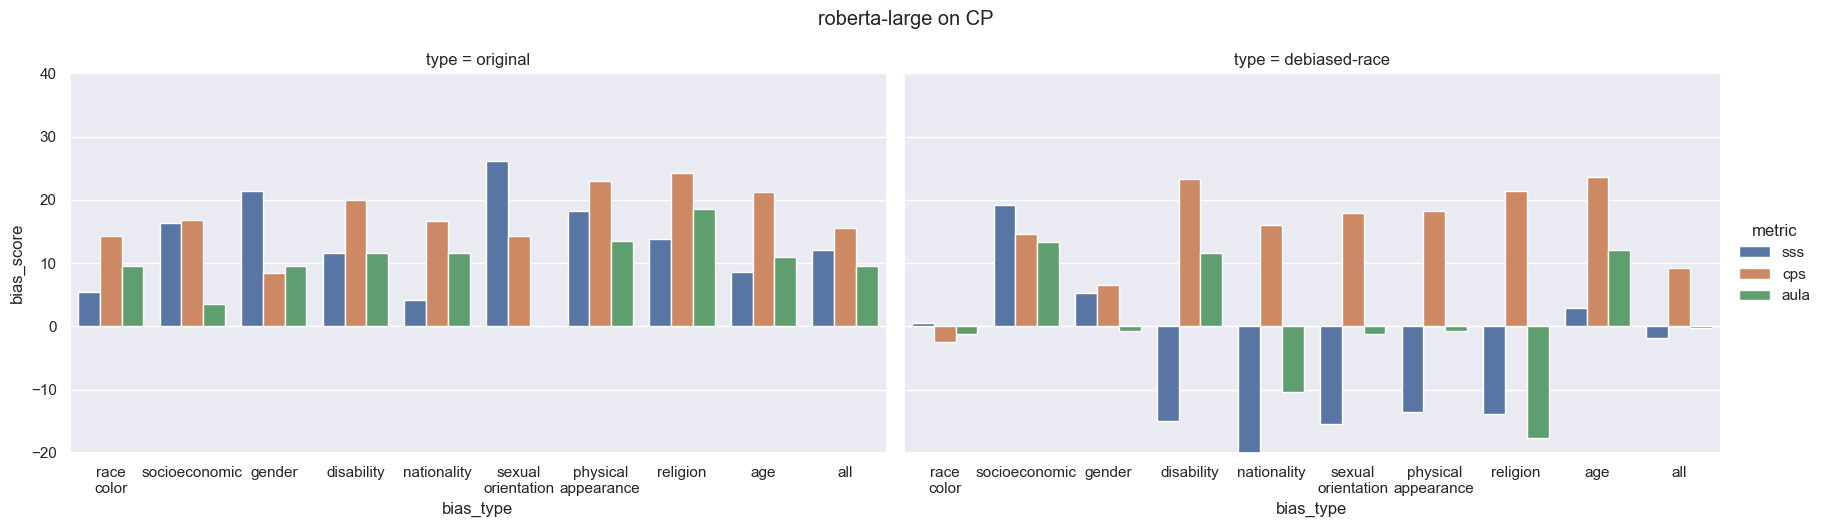

In [78]:
for m in list_of_debiased:
    g = sns.catplot(data=results[(results['data']=='cp') & (results['model']==m)],x='bias_type',y='bias_score', hue='metric', col='type', kind='bar', aspect=1.75)
    g.fig.suptitle(f'{m} on CP', y=1.05)
    plt.ylim(-20,40)

    plt.show()
    
    # for bt in list_of_debiased[m]:
    #     sns.catplot(data=results[(results['data']=='cp') & (results['model']==m+f'-debiased-{bt}')],x='bias_type',y='bias_score', hue='metric', kind='bar', aspect=1.75)
    #     plt.title(f'{m}-debiased-{bt} on CP')
    #     plt.ylim(-20,40)
    #     plt.show()

## SS

Text(0.5, 1.05, 'SS')

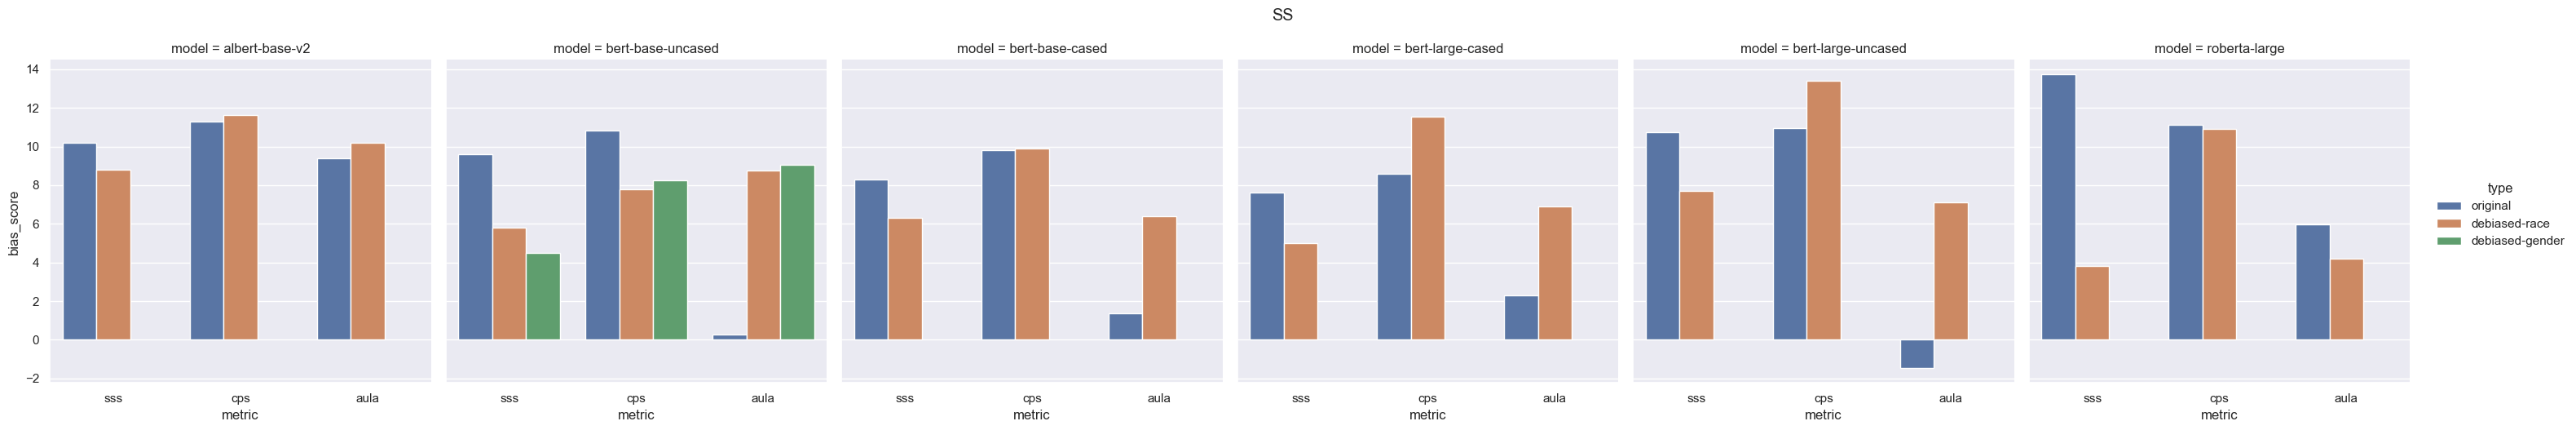

In [80]:
g = sns.catplot(data=results[(results['data']=='ss') & (results['bias_type']=='all')],x='metric',y='bias_score', col='model', hue='type', kind='bar')
g.fig.suptitle(f'SS', y=1.05)

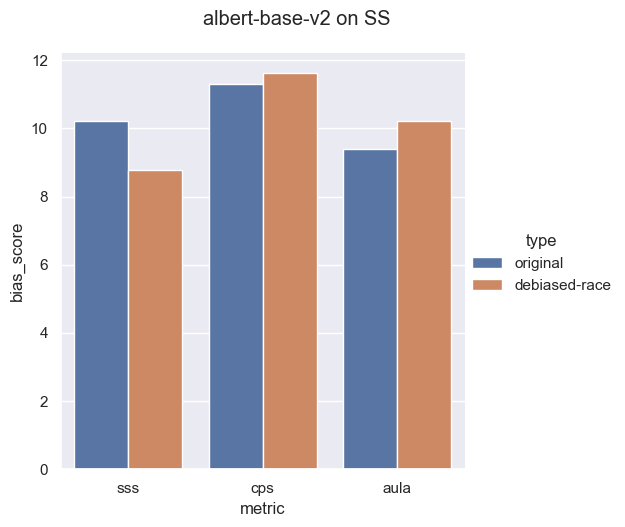

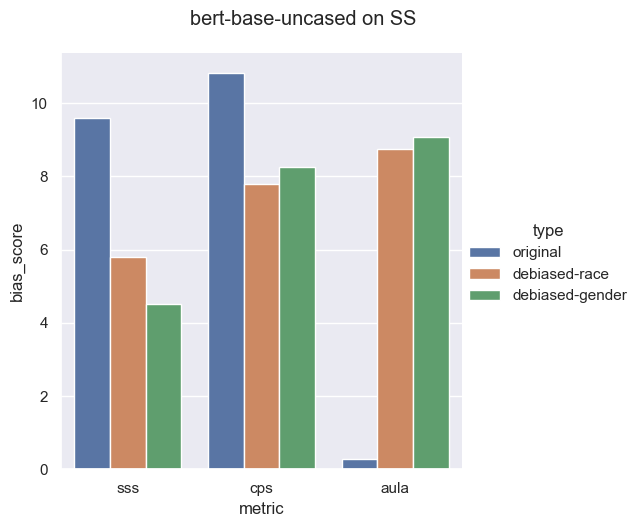

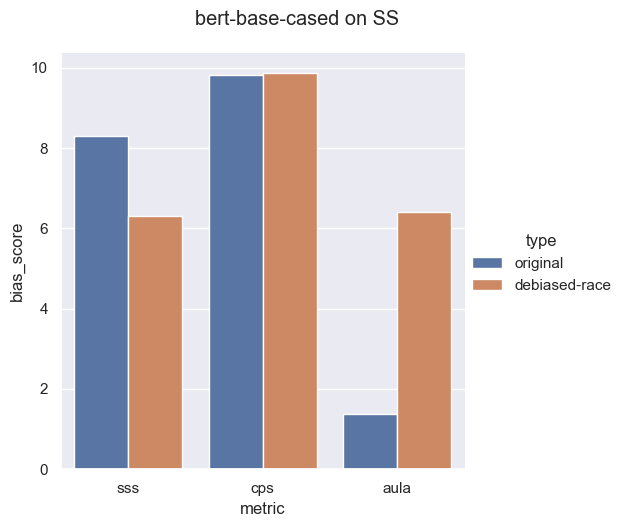

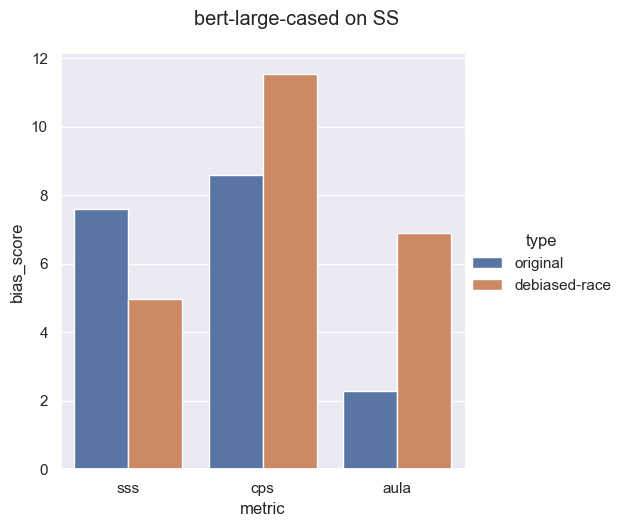

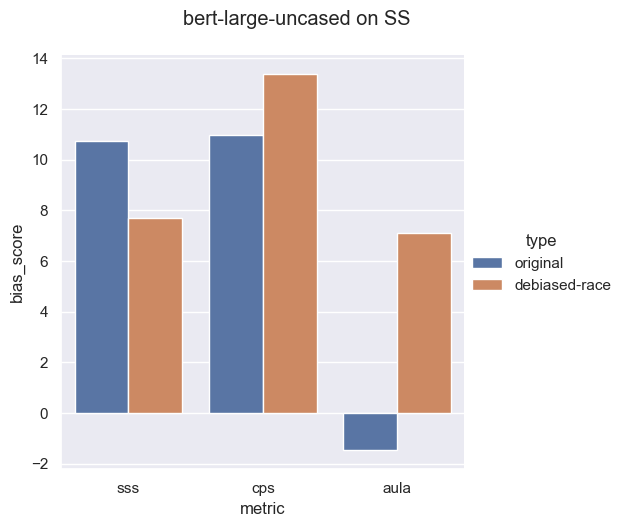

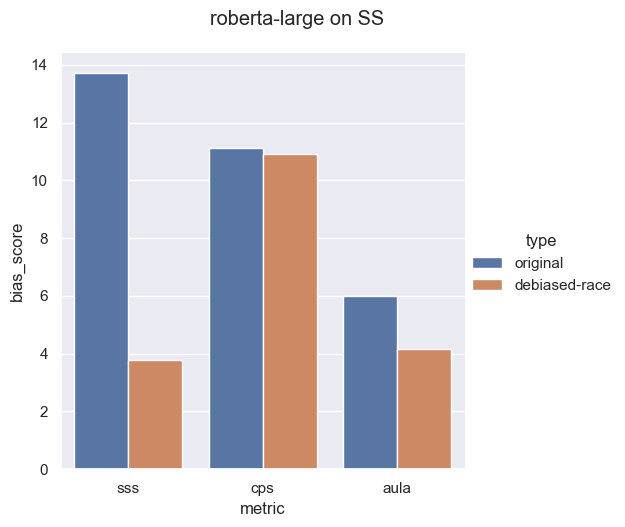

In [81]:
for m in list_of_debiased:
    g = sns.catplot(data=results[(results['data']=='ss') & (results['model']==m) & (results['bias_type']=='all')],x='metric',y='bias_score', hue='type', kind='bar')
    g.fig.suptitle(f'{m} on SS', y=1.05)
    # plt.ylim(-20,40)

    plt.show()
# g = sns.catplot(data=results[results['bias_type']=='all'],kind='bar',x='metric',y='bias_score', hue='data', row='model', col='type')
# plt.show()

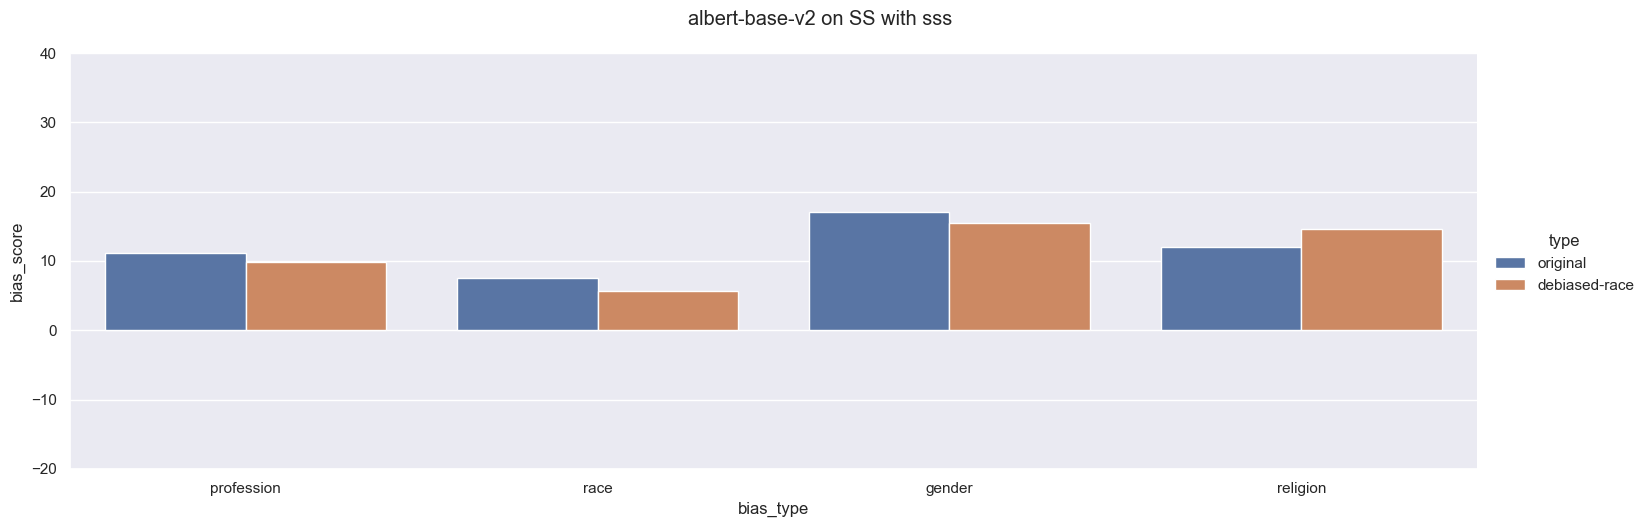

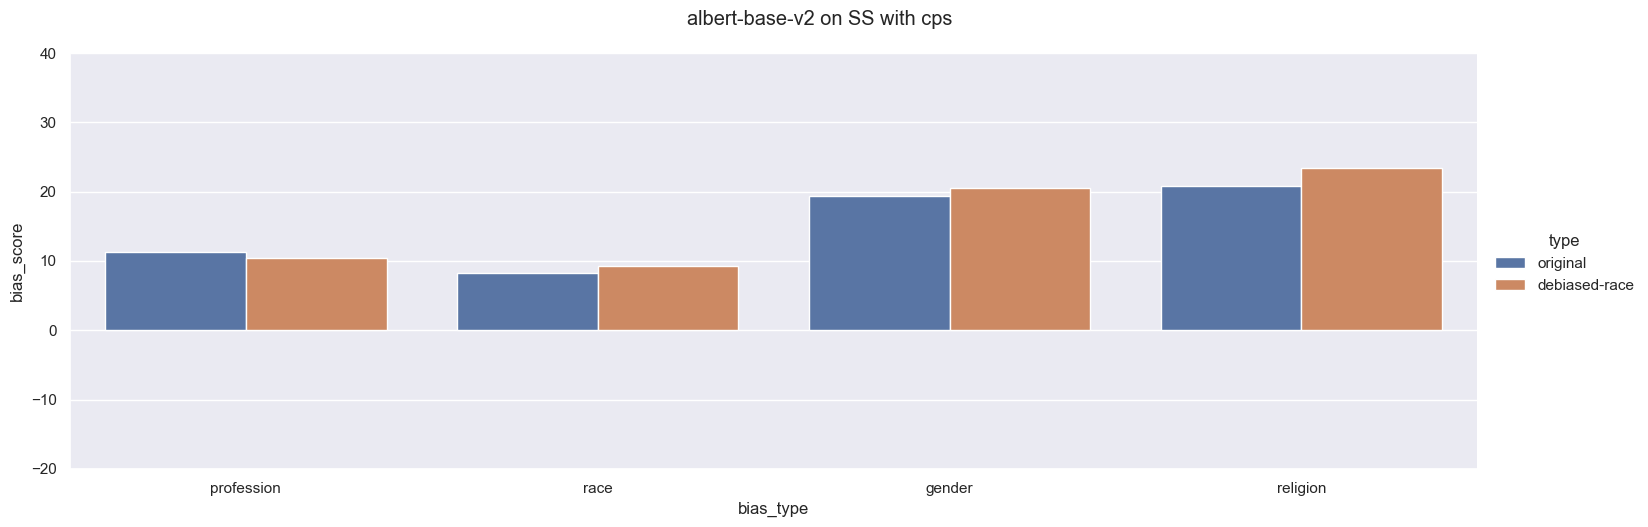

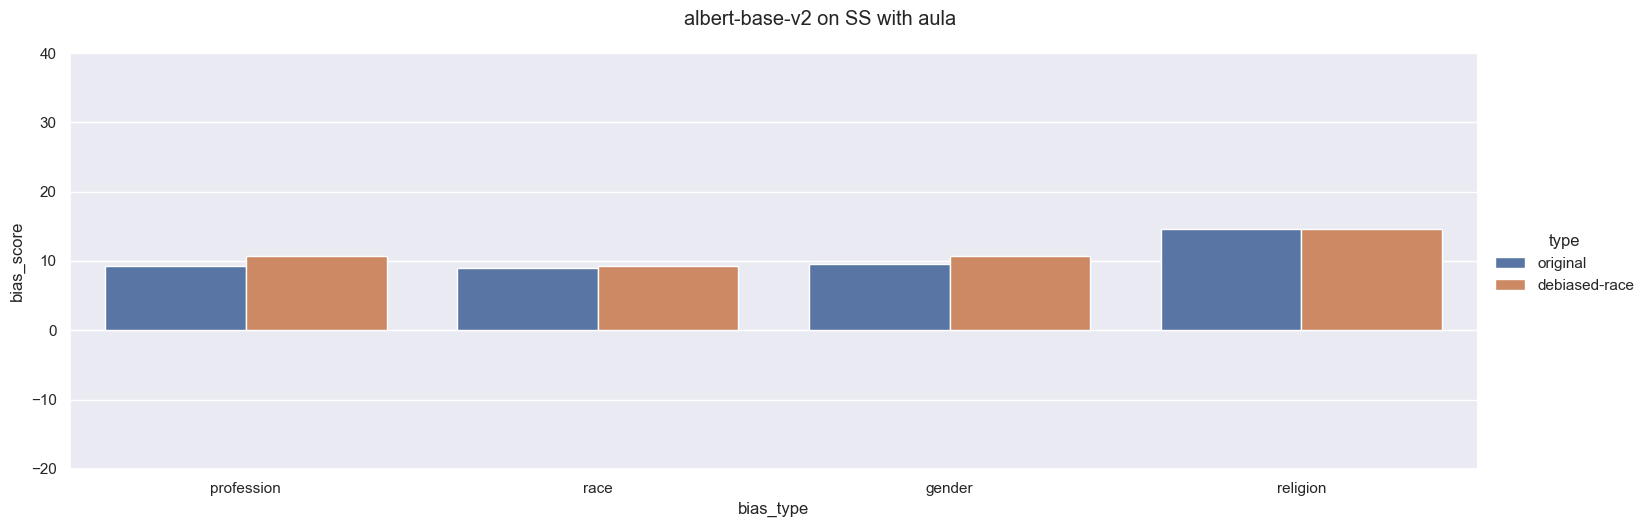

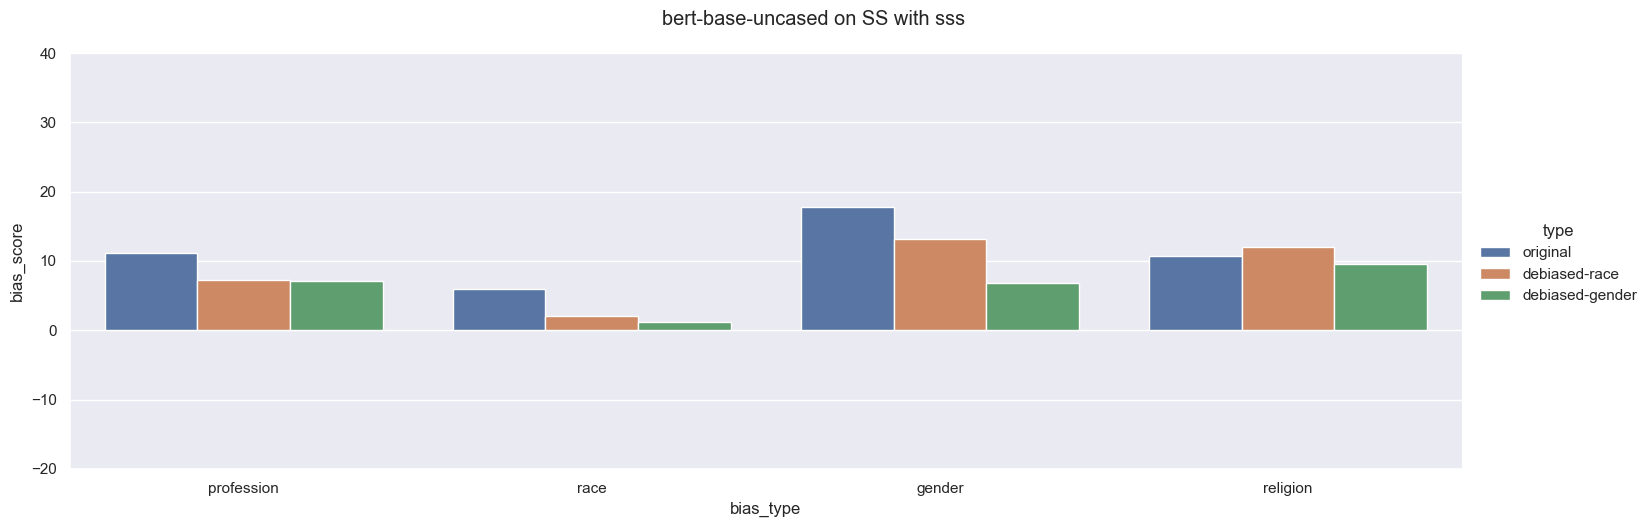

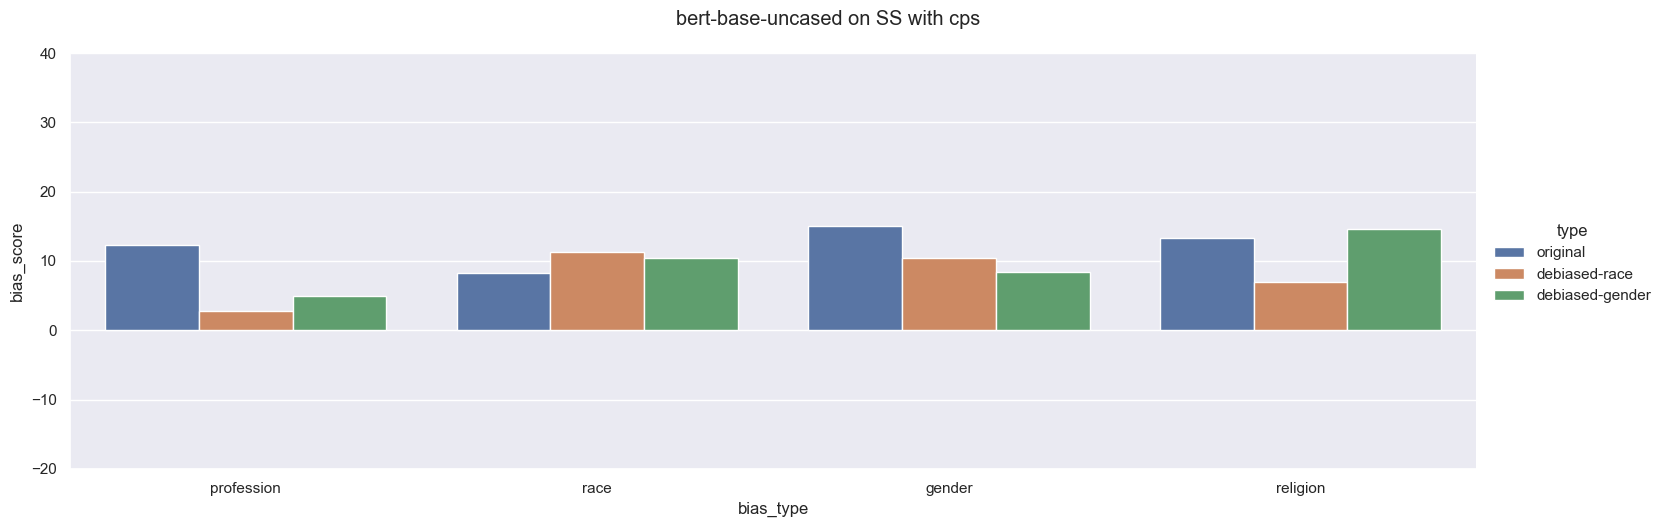

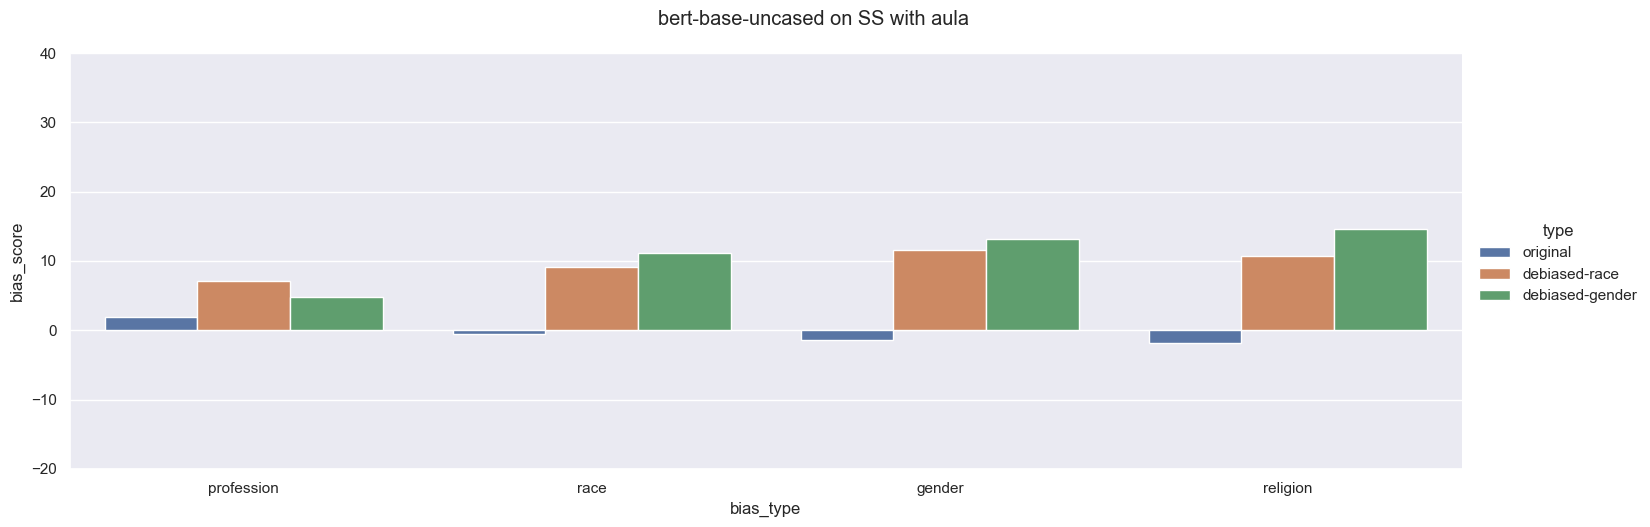

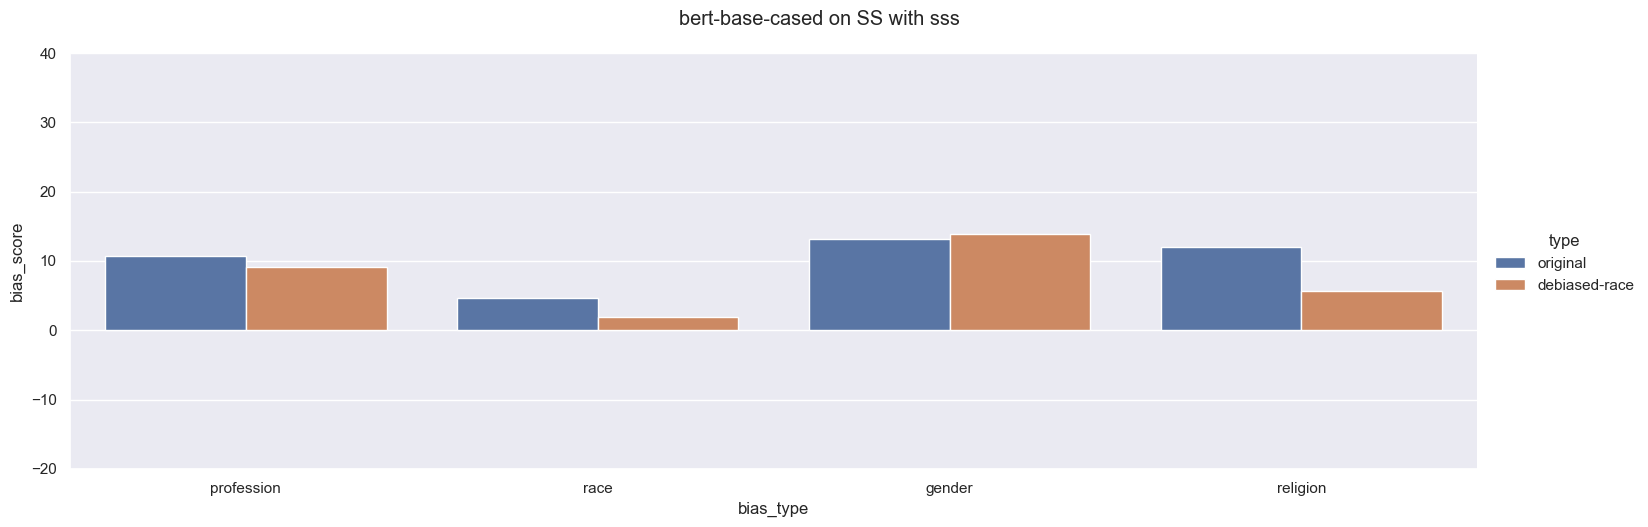

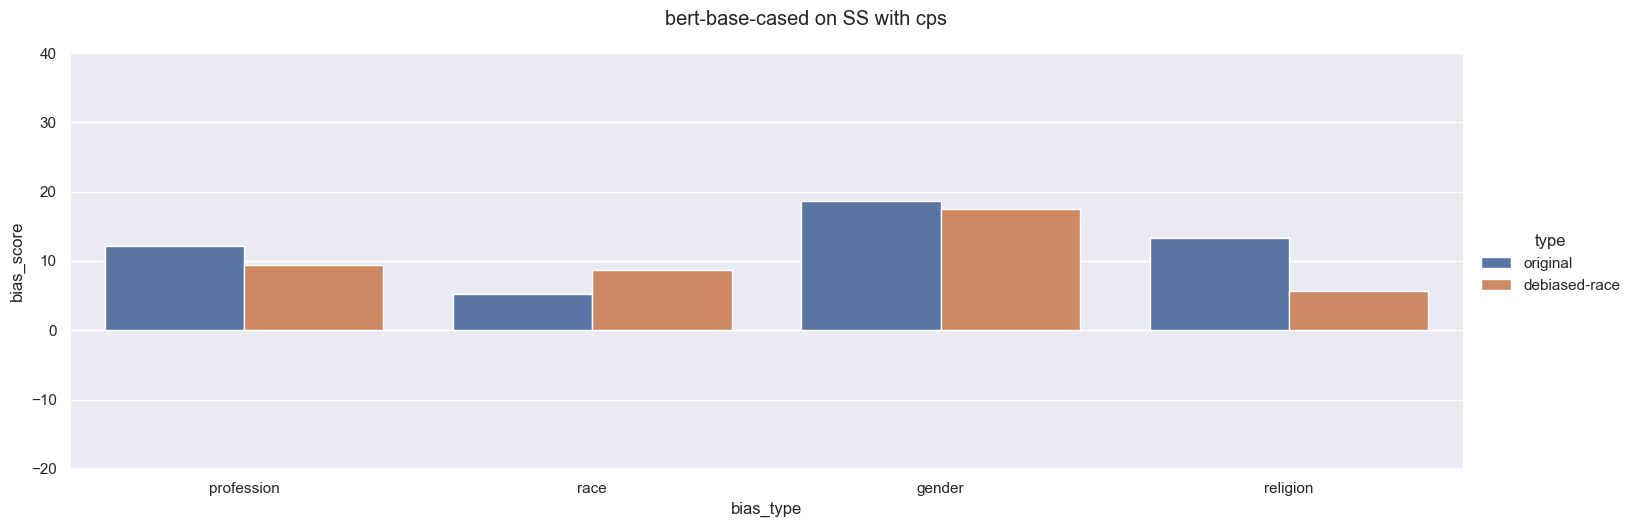

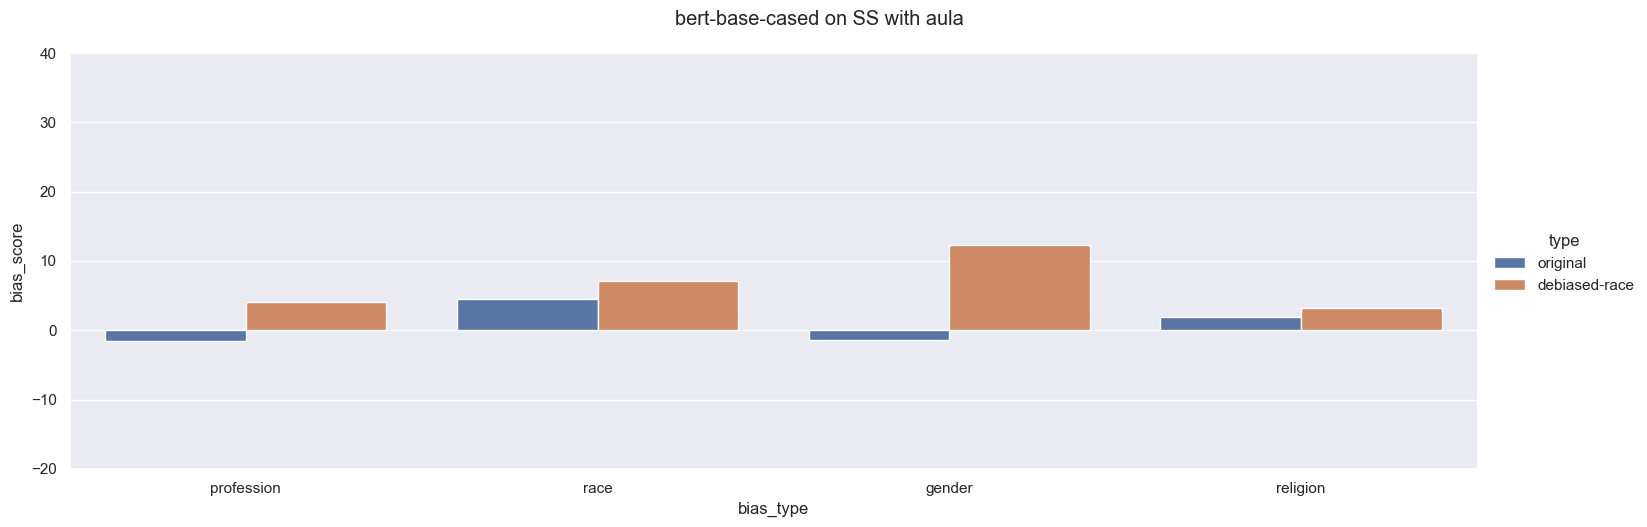

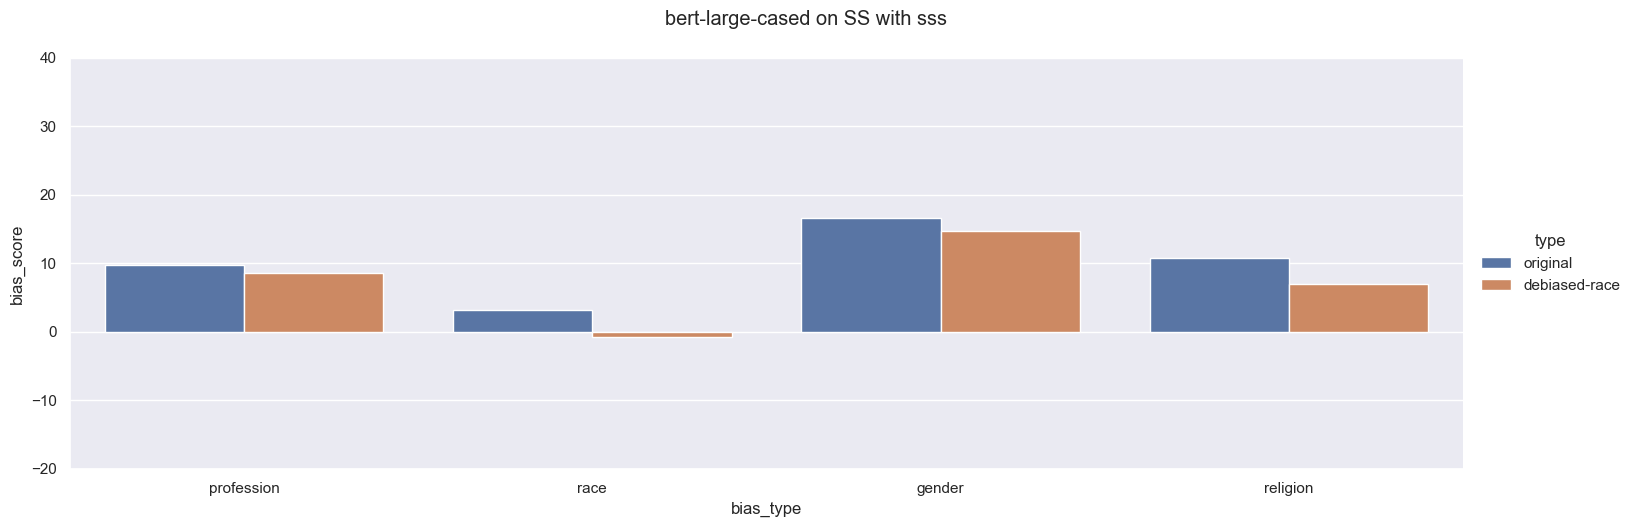

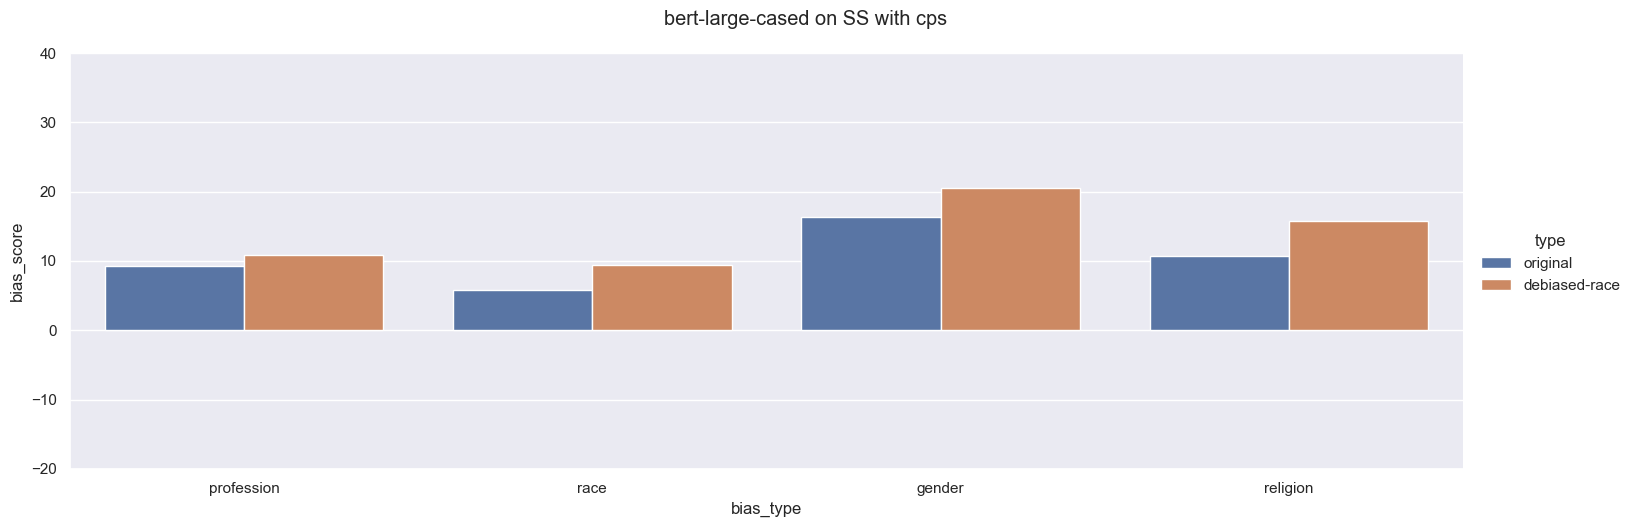

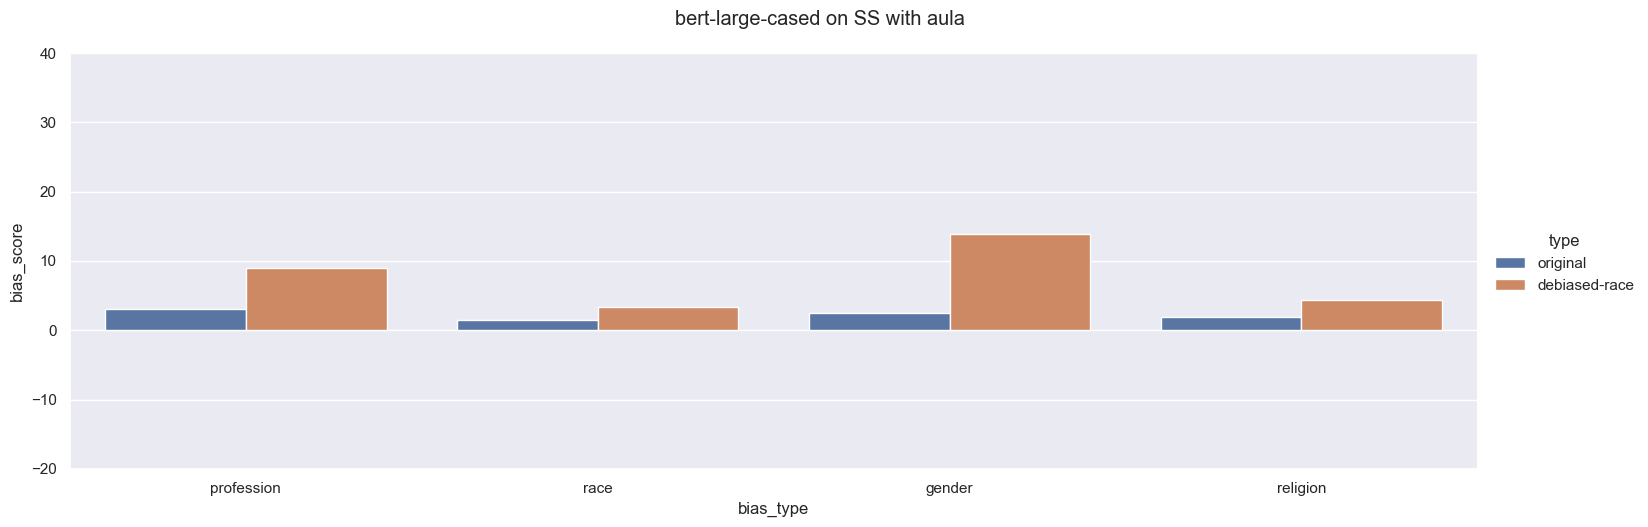

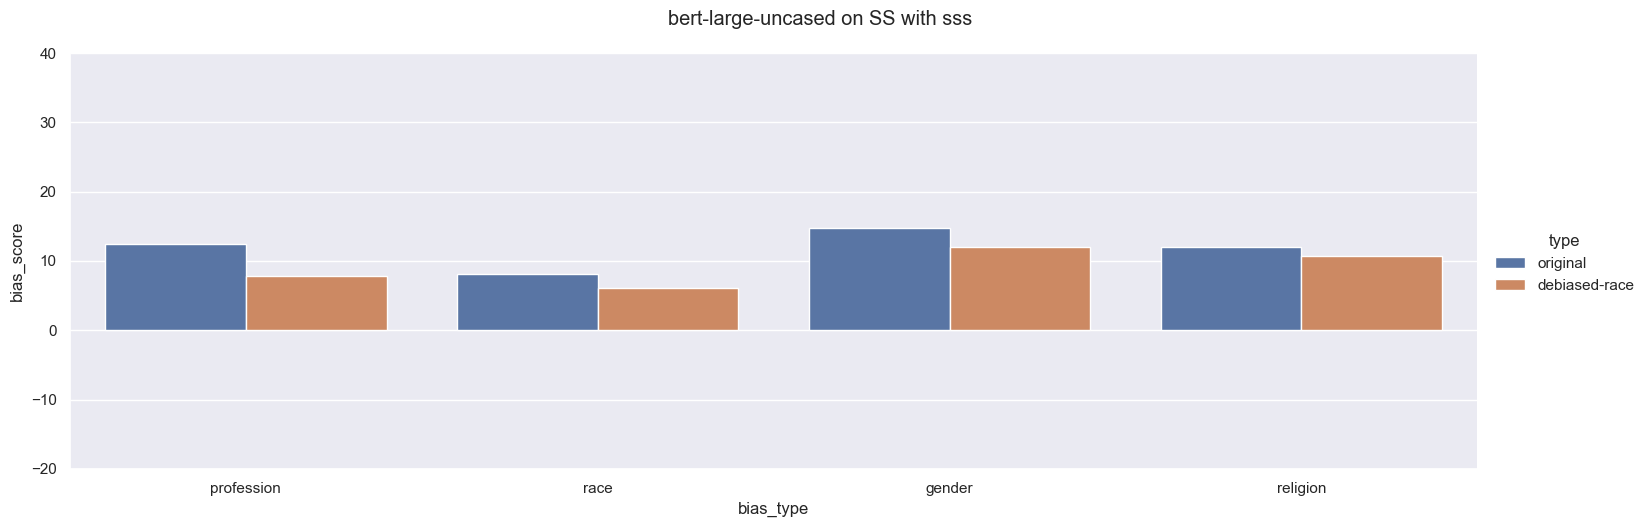

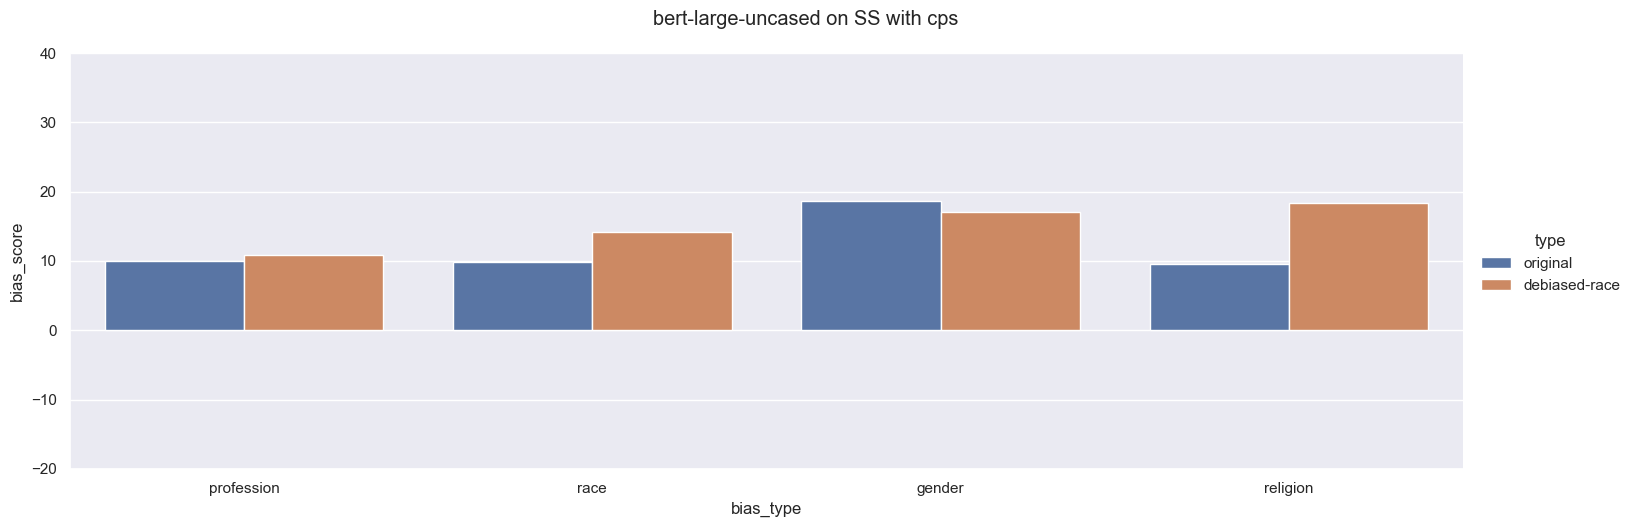

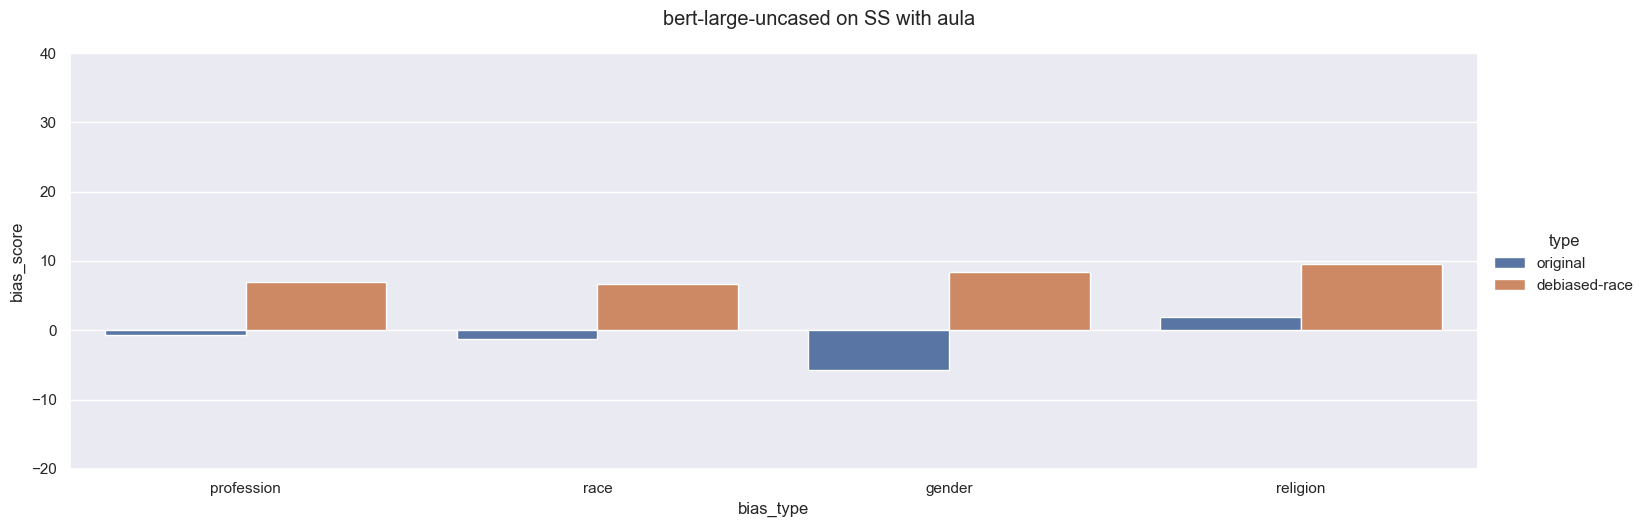

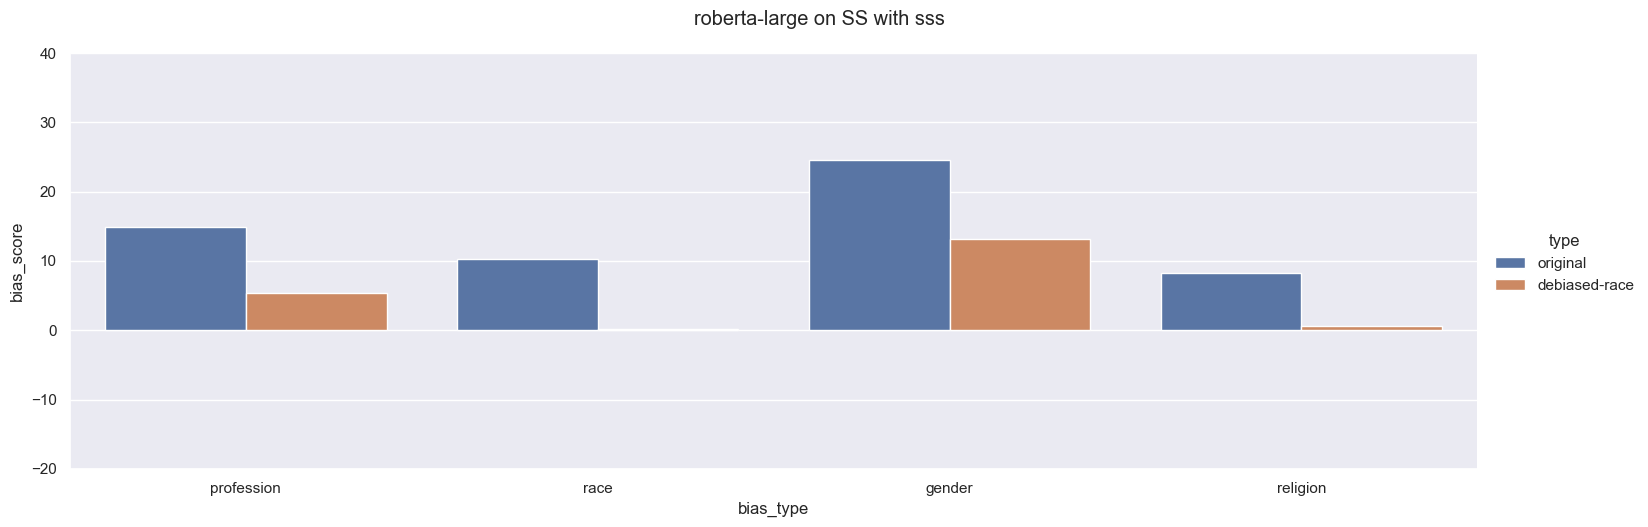

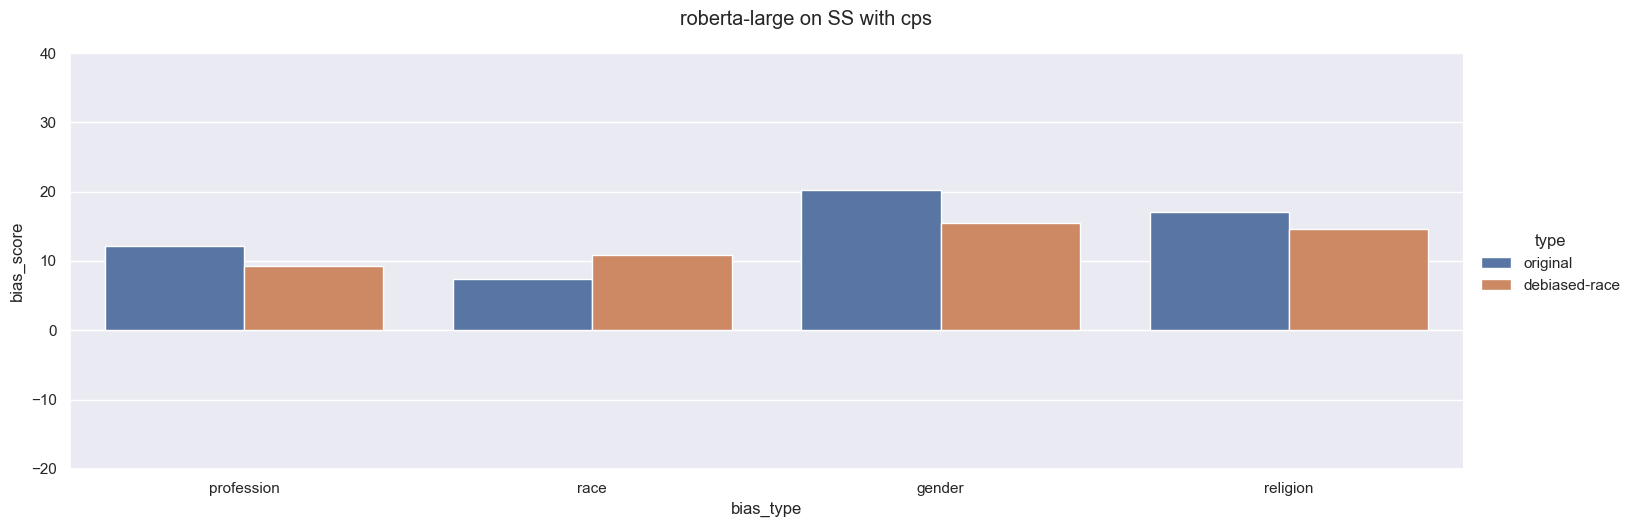

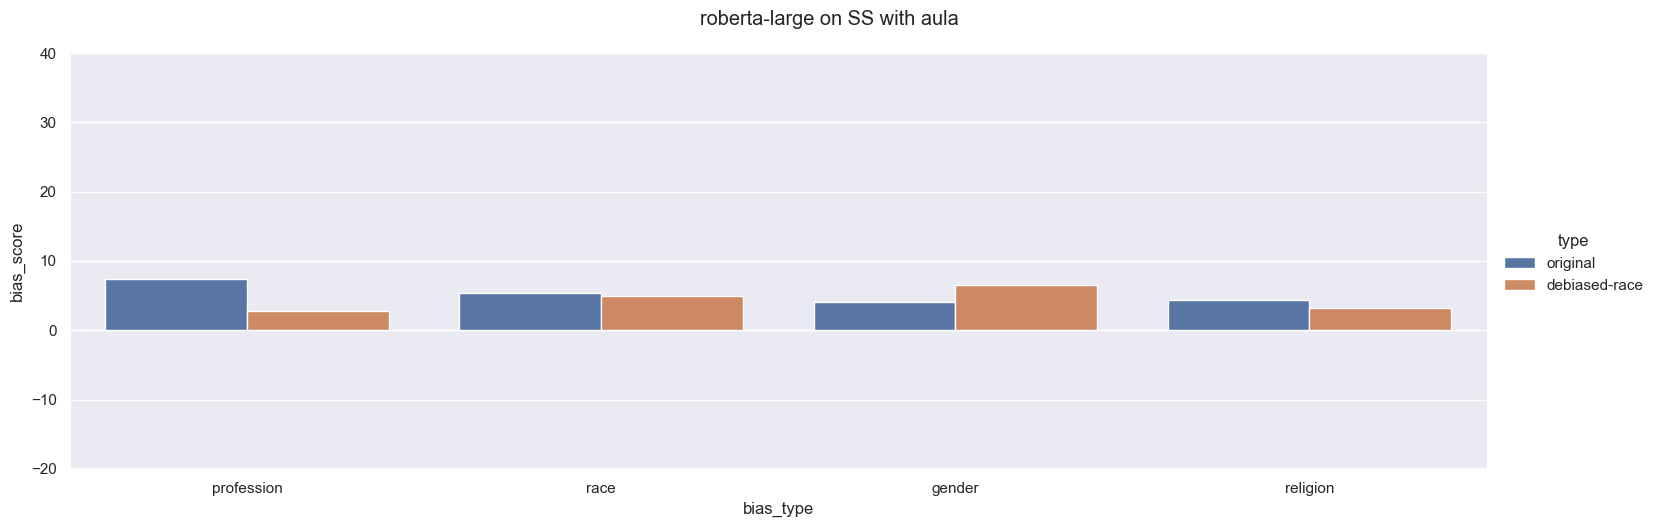

In [82]:
for m in list_of_debiased:
    for met in metrics:
        g = sns.catplot(data=results[(results['data']=='ss') & (results['model']==m) & (results['bias_type']!='all') & (results['metric']==met)],x='bias_type',y='bias_score', hue='type',kind='bar', aspect=3.)
        g.fig.suptitle(f'{m} on SS with {met}', y=1.05)
        plt.ylim(-20,40)

        plt.show()

## Extrinsic

In [71]:
list_of_debiased = {
    'albert-base-v2': ['race'],
    'bert-base-uncased': ['race','gender'],
    'bert-base-cased': ['race'],
    'bert-large-cased': ['race'],
    'bert-large-uncased': ['race'],
    'roberta-large': ['race']
}

occ_stats = pd.read_csv('data/STS/STS-B/occupations-stats.tsv', sep='\t')
pearson_corr = {}

for m in list_of_debiased:
    dataset = pd.read_csv(f'results/{m}/sts-bias.csv', names=['occupation','score'])
    corr, _ = pearsonr(occ_stats['bls_pct_female'], dataset['score'])
    pearson_corr[m] = corr

    for dt in list_of_debiased[m]:
        dataset = pd.read_csv(f'results/{m}/sts-bias_{dt}.csv', names=['occupation','score'])
        corr, _ = pearsonr(occ_stats['bls_pct_female'], dataset['score'])
        pearson_corr[f'{m}-{dt}'] = corr
    

In [72]:
pearson_corr

{'albert-base-v2': 0.2314775794835891,
 'albert-base-v2-race': -0.1586466841046457,
 'bert-base-uncased': -0.4928490390849405,
 'bert-base-uncased-race': -0.24320236039660187,
 'bert-base-uncased-gender': -0.1957667769701159,
 'bert-base-cased': -0.004457780090719871,
 'bert-base-cased-race': 0.12378502954495063,
 'bert-large-cased': 0.05073919541111571,
 'bert-large-cased-race': 0.35543595433326874,
 'bert-large-uncased': -0.4234013472826021,
 'bert-large-uncased-race': -0.43976771080658017,
 'roberta-large': -0.3033425061372752,
 'roberta-large-race': 0.11287540321343052}